In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)
%R library(DropletUtils)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

array(['DropletUtils', 'scran', 'SingleCellExperiment',
       'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'Seurat', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [8]:
from TenX_PDAC_misc_scripts_v1_0 import *
from TenX_PDAC_plot_v1_0 import *
from TenX_PDAC_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202110251102'
path_input = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_input/'
path_output = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_PDAC_Lgr5/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}

# Initialize engines

In [12]:
c = Client()

In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/")')
dview.execute('from TenX_PDAC_misc_scripts_v1_0 import *')
dview.execute('from TenX_PDAC_plot_v1_0 import *')
dview.execute('from TenX_PDAC_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Compile data

X1: Sample1_GH2593_luc_live

X2: Sample2_GH2798

X3: Sample3_GH2807

X4: YY1010_YY1024

X5: YY1017_YY1021

X6: KW1710_veh

X7: XZ1386_veh

X8: KW1714_CD_LGK

X9: KW1718_CD_LGK

X10: 1920_24_29

X11: 1918-1922

X12: mTmG_Day_3

X13: LGK_Day_10

X14: Gem_Day_10

X15: Veh_Day_10

X16: AJ1207_08_12

X17: LGK_Day_20

X18: AK1471_82_83

X19: Day_10_Veh_LGK

X20: 2D_3D_Cells

X21: KPT_062221

X22: KPT_062521

X23: KPT_062821

X24: KPT_070721

X25: KPT_071221

X26: KPT_072021

X27: OG-1221_KPT_081021

X28: OG-1331_Day3_100621

X29: AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag

## X1: Sample1_GH2593_luc_live

### Load AnnData

In [15]:
X1 = sc.read_10x_mtx('%s/20210130_Sample1_GH2593_luc_live_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X1.obs_names = [s.split('-')[0] for s in X1.obs_names]

In [16]:
X1.layers['raw'] = X1.X

### Add transgene counts to metadata

In [17]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [18]:
X1.obs[tgs] = X1[:,tgs].X.todense()

In [19]:
X1 = X1[:,:-8]

### Add metadata

In [20]:
X1.obs['batch'] = 'Sample1_GH2593_luc_live'
X1.obs['mouse'] = 'GH2593'
X1.obs['tumor'] = 'autochthonous'
X1.obs['donor'] = 'None'
X1.obs['treatment'] = 'untreated'
X1.obs['hash'] = 'no_hash'
X1.obs['10X_version'] = 'v2'

Trying to set attribute `.obs` of view, copying.


In [21]:
X1

AnnData object with n_obs × n_vars = 1423 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X2: Sample2_GH2798

### Load AnnData

In [22]:
X2 = sc.read_10x_mtx('%s/20210130_Sample2_GH2798_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X2.obs_names = [s.split('-')[0] for s in X2.obs_names]

In [23]:
X2.layers['raw'] = X2.X

### Add transgene counts to metadata

In [24]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [25]:
X2.obs[tgs] = X2[:,tgs].X.todense()

In [26]:
X2 = X2[:,:-8]

### Add metadata

In [27]:
X2.obs['batch'] = 'Sample2_GH2798'
X2.obs['mouse'] = 'GH2798'
X2.obs['tumor'] = 'autochthonous'
X2.obs['donor'] = 'None'
X2.obs['treatment'] = 'untreated'
X2.obs['hash'] = 'no_hash'
X2.obs['10X_version'] = 'v2'

Trying to set attribute `.obs` of view, copying.


In [28]:
X2

AnnData object with n_obs × n_vars = 1566 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X3: Sample3_GH2807

### Load AnnData

In [29]:
X3 = sc.read_10x_mtx('%s/20210130_Sample3_GH2807_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X3.obs_names = [s.split('-')[0] for s in X3.obs_names]

In [30]:
X3.layers['raw'] = X3.X

### Add transgene counts to metadata

In [31]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [32]:
X3.obs[tgs] = X3[:,tgs].X.todense()

In [33]:
X3 = X3[:,:-8]

### Add metadata

In [34]:
X3.obs['batch'] = 'Sample3_GH2807'
X3.obs['mouse'] = 'GH2807'
X3.obs['tumor'] = 'autochthonous'
X3.obs['donor'] = 'None'
X3.obs['treatment'] = 'untreated'
X3.obs['hash'] = 'no_hash'
X3.obs['10X_version'] = 'v2'

Trying to set attribute `.obs` of view, copying.


## X4: YY1010_YY1024

### Load AnnData

In [35]:
X4 = sc.read_10x_mtx('%s/20210217_YY1010_YY1024_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X4.obs_names = [s.split('-')[0] for s in X4.obs_names]

In [36]:
X4.layers['raw'] = X4.X

In [37]:
H4 = X4[:,-21:]
X4 = X4[:,:-21]

### Assign hashes

In [38]:
hashes = ['HTO1_CiteSeq',
          'HTO2_CiteSeq']

In [39]:
pdH4 = sc2pd(H4, 'raw').loc[hashes]

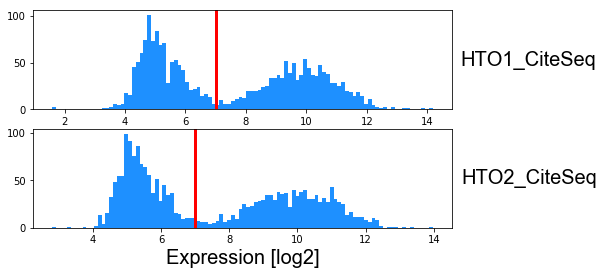

In [40]:
plot_hashes(pdH4, thr = [7,7])

In [41]:
hashes4 = assign_hashes(pdH4, [7,7])

In [42]:
Counter(hashes4)

Counter({'Negative': 134,
         'HTO2_CiteSeq': 915,
         'HTO1_CiteSeq': 928,
         'HTO1_CiteSeq-HTO2_CiteSeq': 139})

### Add transgene counts to metadata

In [43]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [44]:
X4.obs[tgs] = X4[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [45]:
X4 = X4[:,:-8]

### Add metadata

In [46]:
X4.obs['batch'] = 'YY1010_YY1024'
X4.obs['mouse'] = None
X4.obs['tumor'] = 'autochthonous'
X4.obs['donor'] = 'None'
X4.obs['treatment'] = 'vehicle'
X4.obs['hash'] = hashes4
X4.obs['10X_version'] = 'v2'

Trying to set attribute `.obs` of view, copying.


In [47]:
mouse4 = {'HTO1_CiteSeq': 'YY1010', 'HTO2_CiteSeq': 'YY1024'}

In [48]:
X4.obs['mouse'] = [mouse4[i] if i in mouse4 else 'fail' for i in X4.obs['hash']]

In [49]:
X4 = X4[X4.obs['mouse'][X4.obs['mouse']!='fail'].index]

In [50]:
X4

View of AnnData object with n_obs × n_vars = 1843 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X5: YY1017_YY1021

### Load data, run emptyDrops, transfer to AnnData

In [51]:
X5 = sc.read_10x_mtx('%s/20210217_YY1017_YY1021_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X5.obs_names = [s.split('-')[0] for s in X5.obs_names]

In [52]:
X5.layers['raw'] = X5.X

In [53]:
H5 = X5[:,-21:]
X5 = X5[:,:-21]

### Assign hashes

In [54]:
hashes = ['HTO1_CiteSeq',
          'HTO2_CiteSeq']

In [55]:
pdH5 = sc2pd(H5, 'raw').loc[hashes]

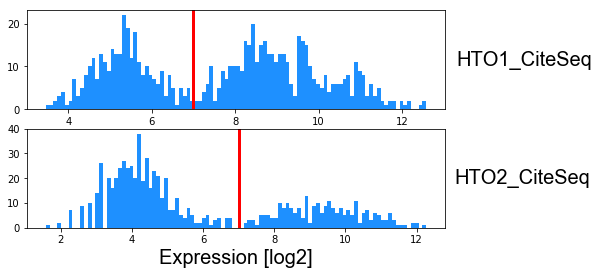

In [56]:
plot_hashes(pdH5, thr = [7,7])

In [57]:
hashes5 = assign_hashes(pdH5, [7,7])

In [58]:
Counter(hashes5)

Counter({'HTO1_CiteSeq': 419,
         'HTO2_CiteSeq': 220,
         'HTO1_CiteSeq-HTO2_CiteSeq': 28,
         'Negative': 80})

### Add transgene counts to metadata

In [59]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [60]:
X5.obs[tgs] = X5[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [61]:
X5 = X5[:,:-8]

### Add metadata

In [62]:
X5.obs['batch'] = 'YY1017_YY1021'
X5.obs['mouse'] = None
X5.obs['tumor'] = 'autochthonous'
X5.obs['donor'] = 'None'
X5.obs['treatment'] = 'LGK-974'
X5.obs['hash'] = hashes5
X5.obs['10X_version'] = 'v2'

Trying to set attribute `.obs` of view, copying.


In [63]:
mouse5 = {'HTO1_CiteSeq': 'YY1017', 'HTO2_CiteSeq': 'YY1021'}

In [64]:
X5.obs['mouse'] = [mouse5[i] if i in mouse5 else 'fail' for i in X5.obs['hash']]

In [65]:
X5 = X5[X5.obs['mouse'][X5.obs['mouse']!='fail'].index]

In [66]:
X5

View of AnnData object with n_obs × n_vars = 639 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X6: KW1710_veh

### Load AnnData

In [67]:
X6 = sc.read_10x_mtx('%s/20210130_KW1710_veh_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X6.obs_names = [s.split('-')[0] for s in X6.obs_names]

In [68]:
X6.layers['raw'] = X6.X

### Add transgene counts to metadata

In [69]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [70]:
X6.obs[tgs] = X6[:,tgs].X.todense()

In [71]:
X6 = X6[:,:-8]

### Add metadata

In [72]:
X6.obs['batch'] = 'KW1710_veh'
X6.obs['mouse'] = 'KW1710'
X6.obs['tumor'] = 'autochthonous'
X6.obs['donor'] = 'None'
X6.obs['treatment'] = 'vehicle'
X6.obs['hash'] = 'no_hash'
X6.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [73]:
X6

AnnData object with n_obs × n_vars = 5822 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X7: XZ1386_veh

### Load AnnData

In [74]:
X7 = sc.read_10x_mtx('%s/20210130_XZ1386_veh_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X7.obs_names = [s.split('-')[0] for s in X7.obs_names]

In [75]:
X7.layers['raw'] = X7.X

### Add transgene counts to metadata

In [76]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [77]:
X7.obs[tgs] = X7[:,tgs].X.todense()

In [78]:
X7 = X7[:,:-8]

### Add metadata

In [79]:
X7.obs['batch'] = 'XZ1386_veh'
X7.obs['mouse'] = 'XZ1386'
X7.obs['tumor'] = 'autochthonous'
X7.obs['donor'] = 'None'
X7.obs['treatment'] = 'vehicle'
X7.obs['hash'] = 'no_hash'
X7.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [80]:
X7

AnnData object with n_obs × n_vars = 8749 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X8: KW1714_CD_LGK

### Load AnnData

In [81]:
X8 = sc.read_10x_mtx('%s/20210130_KW1714_CD_LGK_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X8.obs_names = [s.split('-')[0] for s in X8.obs_names]

In [82]:
X8.layers['raw'] = X8.X

### Add transgene counts to metadata

In [83]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [84]:
X8.obs[tgs] = X8[:,tgs].X.todense()

In [85]:
X8 = X8[:,:-8]

### Add metadata

In [86]:
X8.obs['batch'] = 'KW1714_CD_LGK'
X8.obs['mouse'] = 'KW1714'
X8.obs['tumor'] = 'autochthonous'
X8.obs['donor'] = 'None'
X8.obs['treatment'] = 'LGK-974'
X8.obs['hash'] = 'no_hash'
X8.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [87]:
X8

AnnData object with n_obs × n_vars = 4939 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X9: KW1718_CD_LGK

### Load AnnData

In [88]:
X9 = sc.read_10x_mtx('%s/20210130_KW1718_CD_LGK_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X9.obs_names = [s.split('-')[0] for s in X9.obs_names]

In [89]:
X9.layers['raw'] = X9.X

### Add transgene counts to metadata

In [90]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [91]:
X9.obs[tgs] = X9[:,tgs].X.todense()

In [92]:
X9 = X9[:,:-8]

### Add metadata

In [93]:
X9.obs['batch'] = 'KW1718_CD_LGK'
X9.obs['mouse'] = 'KW1718'
X9.obs['tumor'] = 'autochthonous'
X9.obs['donor'] = 'None'
X9.obs['treatment'] = 'LGK-974'
X9.obs['hash'] = 'no_hash'
X9.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [94]:
X9

AnnData object with n_obs × n_vars = 4755 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X10: 1920_24_29

### Load AnnData

In [95]:
X10 = sc.read_10x_mtx('%s/20210119_1920_24_29_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X10.obs_names = [s.split('-')[0] for s in X10.obs_names]

In [96]:
X10.layers['raw'] = X10.X

In [97]:
H10 = X10[:,-9:]
X10 = X10[:,:-9]

### Assign hashes

In [98]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB']

In [99]:
pdH10 = sc2pd(H10, 'raw').loc[hashes]

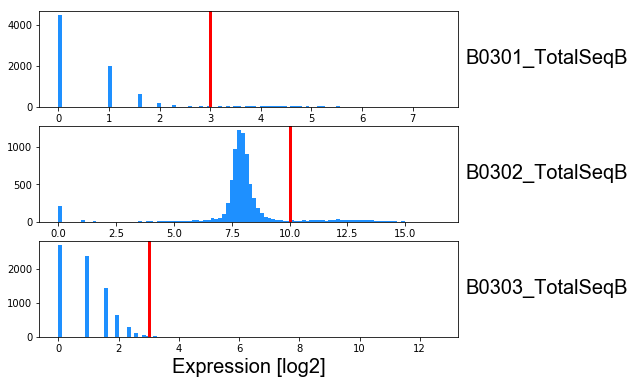

In [100]:
plot_hashes(pdH10, thr = [3,10,3])

In [101]:
hashes10 = assign_hashes(pdH10, [3,10,3])

In [102]:
Counter(hashes10)

Counter({'Negative': 7120,
         'B0302_TotalSeqB': 218,
         'B0301_TotalSeqB-B0302_TotalSeqB': 231,
         'B0303_TotalSeqB': 36,
         'B0301_TotalSeqB-B0302_TotalSeqB-B0303_TotalSeqB': 15,
         'B0301_TotalSeqB': 3,
         'B0301_TotalSeqB-B0303_TotalSeqB': 1,
         'B0302_TotalSeqB-B0303_TotalSeqB': 2})

### Add transgene counts to metadata

In [103]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [104]:
X10.obs[tgs] = X10[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [105]:
X10 = X10[:,:-8]

### Add metadata

In [106]:
X10.obs['batch'] = '1920_24_29'
X10.obs['mouse'] = '1920/1924/1929'
X10.obs['tumor'] = 'NSG_fragment'
X10.obs['donor'] = 'None'
X10.obs['treatment'] = '3d_TAM'
X10.obs['hash'] = hashes10
X10.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [107]:
X10

AnnData object with n_obs × n_vars = 7626 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X11: 1918-1922

### Load AnnData

In [108]:
X11 = sc.read_10x_mtx('%s/20210127_1918-1922_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X11.obs_names = [s.split('-')[0] for s in X11.obs_names]

In [109]:
X11.layers['raw'] = X11.X

In [110]:
H11 = X11[:,-9:]
X11 = X11[:,:-9]

### Assign hashes

In [111]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB']

In [112]:
pdH11 = sc2pd(H11, 'raw').loc[hashes]

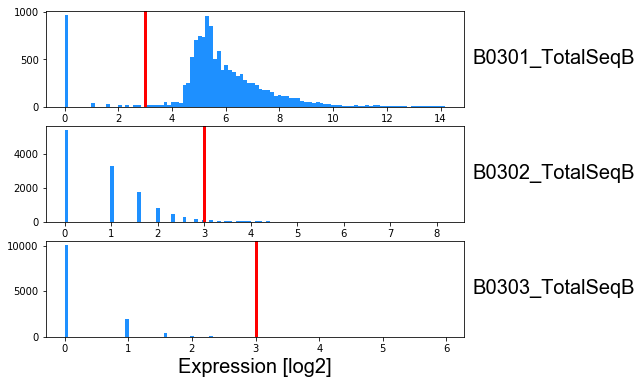

In [113]:
plot_hashes(pdH11, thr = [3,3,3])

In [114]:
hashes11 = assign_hashes(pdH11, [3,3,3])

In [115]:
Counter(hashes11)

Counter({'B0301_TotalSeqB': 11053,
         'B0301_TotalSeqB-B0302_TotalSeqB': 449,
         'Negative': 1127,
         'B0301_TotalSeqB-B0303_TotalSeqB': 1,
         'B0301_TotalSeqB-B0302_TotalSeqB-B0303_TotalSeqB': 74})

### Add transgene counts to metadata

In [116]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [117]:
X11.obs[tgs] = X11[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [118]:
X11 = X11[:,:-8]

### Add metadata

In [119]:
X11.obs['batch'] = '1918_1922'
X11.obs['mouse'] = '1918/1922'
X11.obs['tumor'] = 'NSG_fragment'
X11.obs['donor'] = 'None'
X11.obs['treatment'] = '20d_TAM'
X11.obs['hash'] = hashes11
X11.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [120]:
X11

AnnData object with n_obs × n_vars = 12704 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X12: mTmG_Day_3

### Load AnnData

In [121]:
X12 = sc.read_10x_mtx('%s/20210518_mTmG_Day_3_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X12.obs_names = [s.split('-')[0] for s in X12.obs_names]

In [122]:
X12.layers['raw'] = X12.X

In [123]:
H12 = X12[:,-9:]
X12 = X12[:,:-9]

### Assign hashes

In [124]:
hashes = ['B0306_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB']

In [125]:
pdH12 = sc2pd(H12, 'raw').loc[hashes]

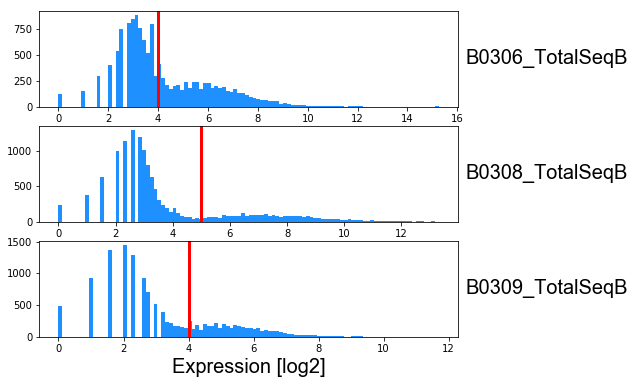

In [126]:
plot_hashes(pdH12, thr = [4,5,4])

In [127]:
hashes12 = assign_hashes(pdH12, [4,5,4])

### Add transgene counts to metadata

In [128]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [129]:
X12.obs[tgs] = X12[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [130]:
X12 = X12[:,:-8]

### Add metadata

In [131]:
X12.obs['batch'] = 'mTmG_Day_3'
X12.obs['mouse'] = None
X12.obs['tumor'] = 'NSG_fragment'
X12.obs['donor'] = None
X12.obs['treatment'] = '3d_TAM'
X12.obs['hash'] = hashes12
X12.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [132]:
mouse12 = {'B0306_TotalSeqB':'107454',
            'B0308_TotalSeqB':'107487',
            'B0309_TotalSeqB':'107485'}

In [133]:
donor12 = {'B0306_TotalSeqB':'AH1861',
            'B0308_TotalSeqB':'AH1822',
            'B0309_TotalSeqB':'AI1518'}

In [134]:
X12.obs['mouse'] = [mouse12[i] if i in mouse12 else 'fail' for i in X12.obs['hash']]
X12.obs['donor'] = [donor12[i] if i in donor12 else 'fail' for i in X12.obs['hash']]

In [135]:
X12

AnnData object with n_obs × n_vars = 13261 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X13: LGK_Day_10

### Load AnnData

In [136]:
X13 = sc.read_10x_mtx('%s/20210518_LGK_Day_10_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X13.obs_names = [s.split('-')[0] for s in X13.obs_names]

In [137]:
X13.layers['raw'] = X13.X

In [138]:
H13 = X13[:,-9:]
X13 = X13[:,:-9]

### Assign hashes

In [139]:
hashes = ['B0307_TotalSeqB',
          'B0306_TotalSeqB',
          'B0309_TotalSeqB']

In [140]:
pdH13 = sc2pd(H13, 'raw').loc[hashes]

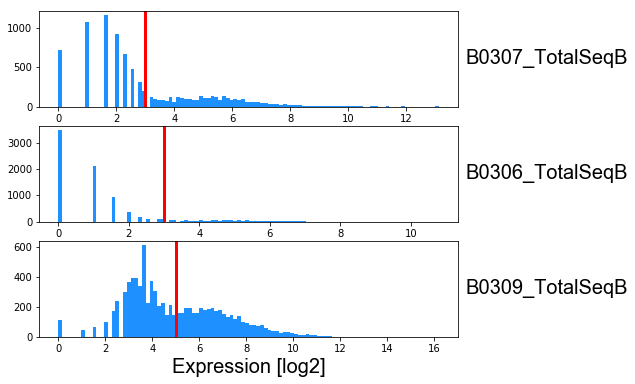

In [141]:
plot_hashes(pdH13, thr = [3,3,5])

In [142]:
hashes13 = assign_hashes(pdH13, [3,3,5])

### Add transgene counts to metadata

In [143]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [144]:
X13.obs[tgs] = X13[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [145]:
X13 = X13[:,:-8]

### Add metadata

In [146]:
X13.obs['batch'] = 'LGK_Day_10'
X13.obs['mouse'] = None
X13.obs['tumor'] = 'NSG_fragment'
X13.obs['donor'] = None
X13.obs['treatment'] = '10d_LGK'
X13.obs['hash'] = hashes13
X13.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [147]:
mouse13 = {'B0307_TotalSeqB':'107455',
           'B0306_TotalSeqB':'107461',
           'B0309_TotalSeqB':'107486'}

In [148]:
donor13 = {'B0307_TotalSeqB':'AH1861',
           'B0306_TotalSeqB':'AH1815',
           'B0309_TotalSeqB':'AH1822'}

In [149]:
X13.obs['mouse'] = [mouse13[i] if i in mouse13 else 'fail' for i in X13.obs['hash']]
X13.obs['donor'] = [donor13[i] if i in donor13 else 'fail' for i in X13.obs['hash']]

In [150]:
X13

AnnData object with n_obs × n_vars = 8686 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X14: Gem_Day_10

### Load AnnData

In [151]:
X14 = sc.read_10x_mtx('%s/20210518_Gem_Day_10_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X14.obs_names = [s.split('-')[0] for s in X14.obs_names]

In [152]:
X14.layers['raw'] = X14.X

In [153]:
H14 = X14[:,-9:]
X14 = X14[:,:-9]

### Assign hashes

In [154]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB']

In [155]:
pdH14 = sc2pd(H14, 'raw').loc[hashes]

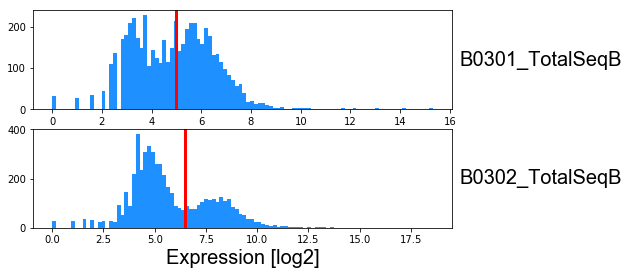

In [156]:
plot_hashes(pdH14, thr = [5,6.5])

In [157]:
hashes14 = assign_hashes(pdH14, [5,6.5])

### Add transgene counts to metadata

In [158]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [159]:
X14.obs[tgs] = X14[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [160]:
X14 = X14[:,:-8]

### Add metadata

In [161]:
X14.obs['batch'] = 'Gem_Day_10'
X14.obs['mouse'] = None
X14.obs['tumor'] = 'NSG_fragment'
X14.obs['donor'] = None
X14.obs['treatment'] = '10d_Gem'
X14.obs['hash'] = hashes14
X14.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [162]:
mouse14 = {'B0301_TotalSeqB':'107460',
           'B0302_TotalSeqB':'107473'}

In [163]:
donor14 = {'B0301_TotalSeqB':'AH1815',
           'B0302_TotalSeqB':'AI1347'}

In [164]:
X14.obs['mouse'] = [mouse14[i] if i in mouse14 else 'fail' for i in X14.obs['hash']]
X14.obs['donor'] = [donor14[i] if i in donor14 else 'fail' for i in X14.obs['hash']]

In [165]:
X14

AnnData object with n_obs × n_vars = 5402 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X15: Veh_Day_10

### Load AnnData

In [166]:
X15 = sc.read_10x_mtx('%s/20210518_Veh_Day_10_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X15.obs_names = [s.split('-')[0] for s in X15.obs_names]

In [167]:
X15.layers['raw'] = X15.X

In [168]:
H15 = X15[:,-9:]
X15 = X15[:,:-9]

### Assign hashes

In [169]:
hashes = ['B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB']

In [170]:
pdH15 = sc2pd(H15, 'raw').loc[hashes]

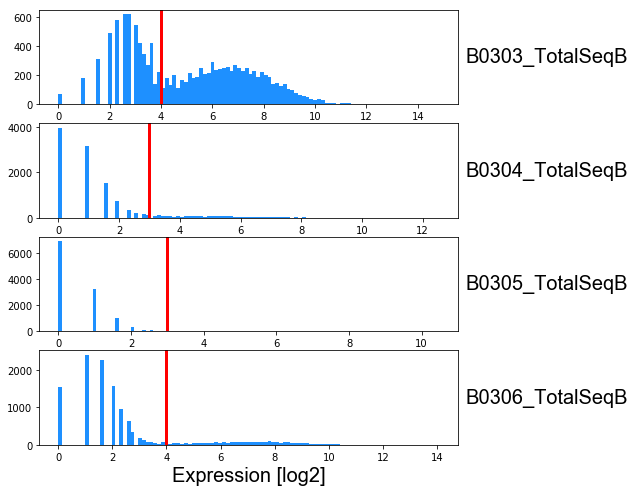

In [171]:
plot_hashes(pdH15, thr = [4,3,3,4])

In [172]:
hashes15 = assign_hashes(pdH15, [4,3,3,4])

### Add transgene counts to metadata

In [173]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [174]:
X15.obs[tgs] = X15[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [175]:
X15 = X15[:,:-8]

### Add metadata

In [176]:
X15.obs['batch'] = 'Veh_Day_10'
X15.obs['mouse'] = None
X15.obs['tumor'] = 'NSG_fragment'
X15.obs['donor'] = None
X15.obs['treatment'] = '10d_Veh'
X15.obs['hash'] = hashes15
X15.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [177]:
mouse15 = {'B0303_TotalSeqB':'107452',
          'B0304_TotalSeqB':'107476',
          'B0305_TotalSeqB':'107465',
          'B0306_TotalSeqB':'107488'}

In [178]:
donor15 = {'B0303_TotalSeqB':'AH1861',
          'B0304_TotalSeqB':'AH1822',
          'B0305_TotalSeqB':'AH1815',
          'B0306_TotalSeqB':'AI1518'}

In [179]:
X15.obs['mouse'] = [mouse15[i] if i in mouse15 else 'fail' for i in X15.obs['hash']]
X15.obs['donor'] = [donor15[i] if i in donor15 else 'fail' for i in X15.obs['hash']]

In [180]:
X15

AnnData object with n_obs × n_vars = 12640 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X16: AJ1207_08_12

### Load AnnData

In [181]:
X16 = sc.read_10x_mtx('%s/20210518_AJ1207_08_12_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X16.obs_names = [s.split('-')[0] for s in X16.obs_names]

In [182]:
X16.layers['raw'] = X16.X

In [183]:
H16 = X16[:,-10:]
X16 = X16[:,:-10]

### Assign hashes

In [184]:
hashes = ['B0307_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [185]:
pdH16 = sc2pd(H16, 'raw').loc[hashes]

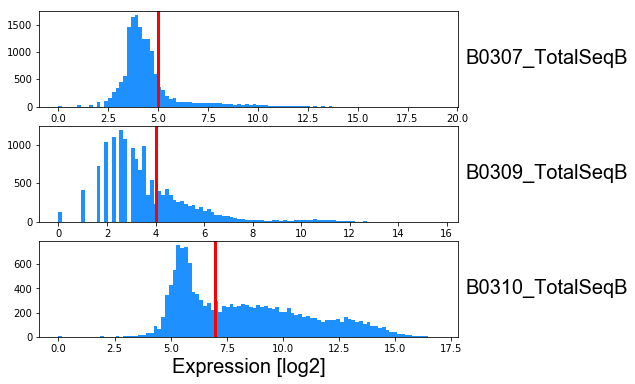

In [186]:
plot_hashes(pdH16, thr = [5,4,7])

In [187]:
hashes16 = assign_hashes(pdH16, [5,4,7])

### Add transgene counts to metadata

In [188]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [189]:
X16.obs[tgs] = X16[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [190]:
X16 = X16[:,:-8]

### Add metadata

In [191]:
X16.obs['batch'] = 'AJ1207_08_12'
X16.obs['mouse'] = None
X16.obs['tumor'] = None
X16.obs['treatment'] = 'untreated'
X16.obs['donor'] = None
X16.obs['hash'] = hashes16
X16.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [192]:
mouse16 = {'B0307_TotalSeqB':'AJ1207',
           'B0309_TotalSeqB':'AJ1208',
           'B0310_TotalSeqB':'AJ1212'}

In [193]:
donor16 = {'B0307_TotalSeqB':'AI1452',
           'B0309_TotalSeqB':'AI1452',
           'B0310_TotalSeqB':'AI1452'}

In [194]:
tumor16 = {'B0307_TotalSeqB':'NSG_fragment',
           'B0309_TotalSeqB':'NSG_fragment',
           'B0310_TotalSeqB':'NSG_sorted'}

In [195]:
X16.obs['mouse'] = [mouse16[i] if i in mouse16 else 'fail' for i in X16.obs['hash']]
X16.obs['donor'] = [donor16[i] if i in donor16 else 'fail' for i in X16.obs['hash']]
X16.obs['tumor'] = [tumor16[i] if i in tumor16 else 'fail' for i in X16.obs['hash']]

In [196]:
X16

AnnData object with n_obs × n_vars = 14974 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'treatment', 'donor', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X17: LGK_Day_20

### Load AnnData

In [197]:
X17 = sc.read_10x_mtx('%s/20210518_LGK_Day_20_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X17.obs_names = [s.split('-')[0] for s in X17.obs_names]

In [198]:
X17.layers['raw'] = X17.X

In [199]:
H17 = X17[:,-10:]
X17 = X17[:,:-10]

### Assign hashes

In [200]:
hashes = ['B0307_TotalSeqB',
          'B0310_TotalSeqB']

In [201]:
pdH17 = sc2pd(H17, 'raw').loc[hashes]

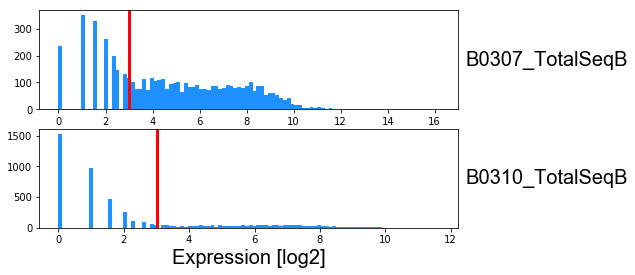

In [202]:
plot_hashes(pdH17, thr = [3,3])

In [203]:
hashes17 = assign_hashes(pdH17, [3,3])

### Add transgene counts to metadata

In [204]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [205]:
X17.obs[tgs] = X17[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [206]:
X17 = X17[:,:-8]

### Add metadata

In [207]:
X17.obs['batch'] = 'LGK_Day_20'
X17.obs['mouse'] = None
X17.obs['tumor'] = 'NSG_fragment'
X17.obs['donor'] = None
X17.obs['treatment'] = '20d_LGK'
X17.obs['hash'] = hashes17
X17.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [208]:
mouse17 = {'B0307_TotalSeqB':'107458',
          'B0310_TotalSeqB':'107459'}

In [209]:
donor17 = {'B0307_TotalSeqB':'AH1861',
          'B0310_TotalSeqB':'AH1815'}

In [210]:
X17.obs['mouse'] = [mouse17[i] if i in mouse17 else 'fail' for i in X17.obs['hash']]
X17.obs['donor'] = [donor17[i] if i in donor17 else 'fail' for i in X17.obs['hash']]

In [211]:
X17

AnnData object with n_obs × n_vars = 5279 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X18: AK1471_82_83

### Load AnnData

In [212]:
X18 = sc.read_10x_mtx('%s/20210625_AK1471_82_83_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X18.obs_names = [s.split('-')[0] for s in X18.obs_names]

In [213]:
X18.layers['raw'] = X18.X

In [214]:
H18 = X18[:,-10:]
X18 = X18[:,:-10]

### Assign hashes

In [215]:
hashes = ['B0305_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [216]:
pdH18 = sc2pd(H18, 'raw').loc[hashes]

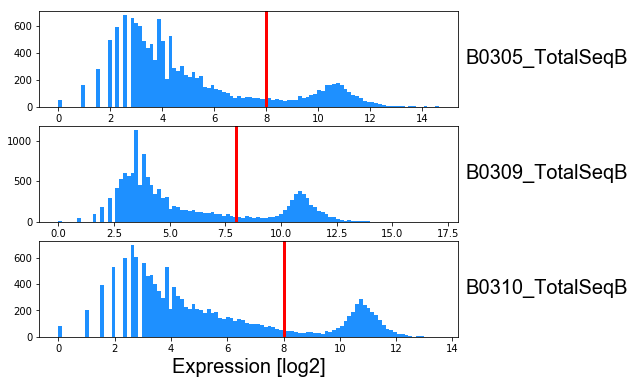

In [217]:
plot_hashes(pdH18, thr = [8,8,8])

In [218]:
hashes18 = assign_hashes(pdH18, [8,8,8])

### Add transgene counts to metadata

In [219]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [220]:
X18.obs[tgs] = X18[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [221]:
X18 = X18[:,:-8]

### Add metadata

In [222]:
X18.obs['batch'] = 'AK1471_82_83'
X18.obs['mouse'] = None
X18.obs['tumor'] = 'autochthonous'
X18.obs['donor'] = 'None'
X18.obs['treatment'] = 'untreated'
X18.obs['hash'] = hashes18
X18.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [223]:
mouse18 = {'B0305_TotalSeqB':'AK1471',
           'B0309_TotalSeqB':'AK1482',
           'B0310_TotalSeqB':'AK1483'}

In [224]:
X18.obs['mouse'] = [mouse18[i] if i in mouse18 else 'fail' for i in X18.obs['hash']]

In [225]:
X18

AnnData object with n_obs × n_vars = 13930 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X19: Day_10_Veh_LGK

### Load AnnData

In [226]:
X19 = sc.read_10x_mtx('%s/20210803_Day_10_Veh_LGK_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X19.obs_names = [s.split('-')[0] for s in X19.obs_names]

In [227]:
X19.layers['raw'] = X19.X

In [228]:
H19 = X19[:,-10:]
X19 = X19[:,:-10]

### Assign hashes

In [229]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0310_TotalSeqB',]

In [230]:
pdH19 = sc2pd(H19, 'raw').loc[hashes]

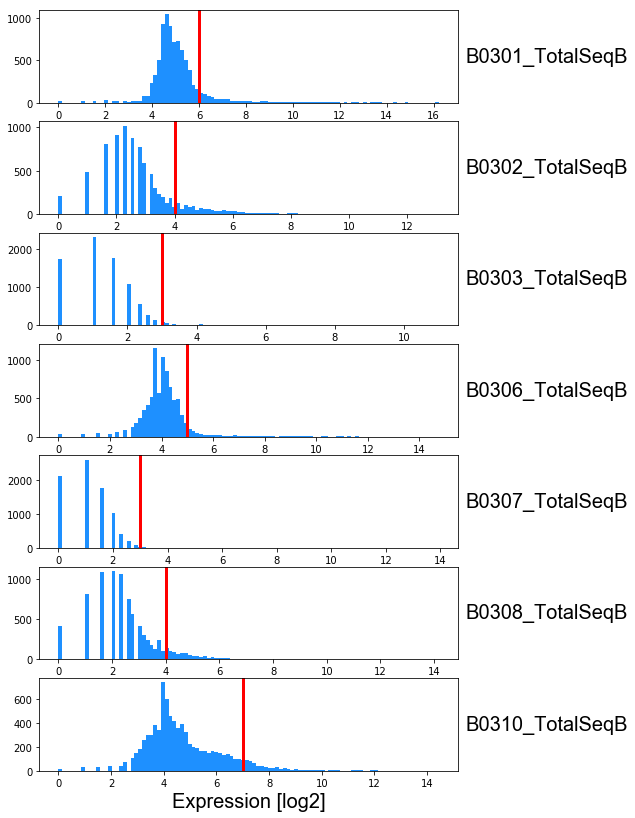

In [231]:
plot_hashes(pdH19, thr = [6,4,3,5,3,4,7])

In [232]:
hashes19 = assign_hashes(pdH19, [6,4,3,5,3,4,7])

### Add transgene counts to metadata

In [233]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [234]:
X19.obs[tgs] = X19[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [235]:
X19 = X19[:,:-8]

### Add metadata

In [236]:
X19.obs['batch'] = 'Day_10_Veh_LGK'
X19.obs['mouse'] = None
X19.obs['tumor'] = 'NSG_fragment'
X19.obs['donor'] = None
X19.obs['treatment'] = None
X19.obs['hash'] = hashes19
X19.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [237]:
mouse19 = {'B0301_TotalSeqB':'AJ1342',
           'B0302_TotalSeqB':'AJ1345',
           'B0303_TotalSeqB':'AJ1349',
           'B0306_TotalSeqB':'AJ1334',
           'B0307_TotalSeqB':'AJ1337',
           'B0308_TotalSeqB':'AJ1347',
           'B0310_TotalSeqB':'AJ1355',}

In [238]:
donor19 = {'B0301_TotalSeqB':'AJ1101',
           'B0302_TotalSeqB':'AJ1101',
           'B0303_TotalSeqB':'AJ1025',
           'B0306_TotalSeqB':'AJ1101',
           'B0307_TotalSeqB':'AJ1101',
           'B0308_TotalSeqB':'AJ1025',
           'B0310_TotalSeqB':'AJ1760',}

In [239]:
treatment19 = {'B0301_TotalSeqB':'10d_LGK',
               'B0302_TotalSeqB':'10d_LGK',
               'B0303_TotalSeqB':'10d_LGK',
               'B0306_TotalSeqB':'10d_Veh',
               'B0307_TotalSeqB':'10d_Veh',
               'B0308_TotalSeqB':'10d_Veh',
               'B0310_TotalSeqB':'10d_Veh',}

In [240]:
X19.obs['mouse'] = [mouse19[i] if i in mouse19 else 'fail' for i in X19.obs['hash']]
X19.obs['donor'] = [donor19[i] if i in donor19 else 'fail' for i in X19.obs['hash']]
X19.obs['treatment'] = [treatment19[i] if i in treatment19 else 'fail' for i in X19.obs['hash']]

In [241]:
X19

AnnData object with n_obs × n_vars = 8406 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X20: 2D_3D_Cells

### Load AnnData

In [242]:
X20 = sc.read_10x_mtx('%s/20210803_2D_3D_Cells_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X20.obs_names = [s.split('-')[0] for s in X20.obs_names]

In [243]:
X20.layers['raw'] = X20.X

In [244]:
H20 = X20[:,-10:]
X20 = X20[:,:-10]

### Assign hashes

In [245]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB',]

In [246]:
pdH20 = sc2pd(H20, 'raw').loc[hashes]

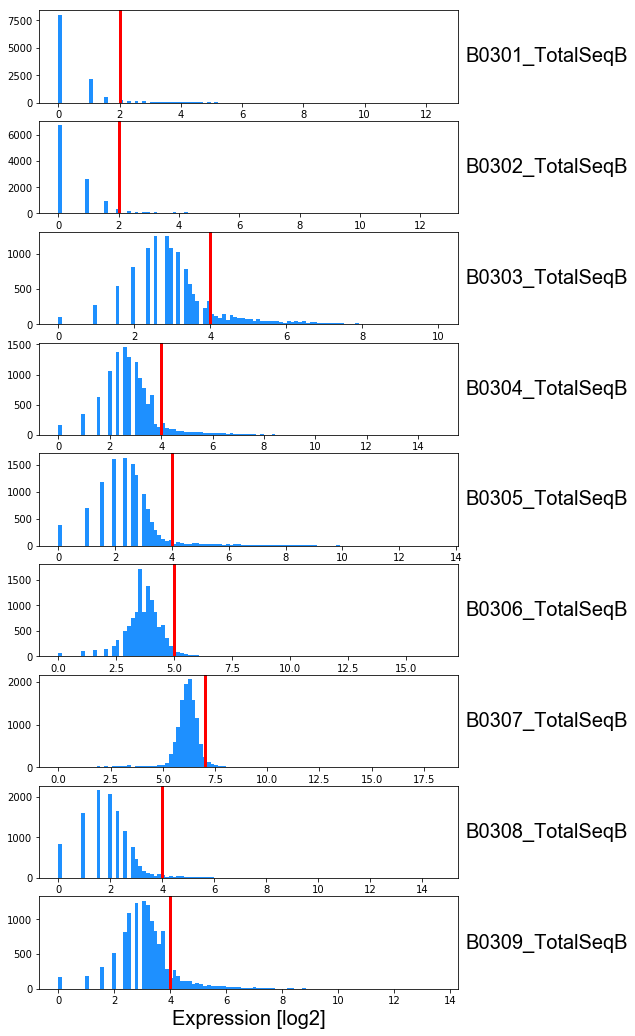

In [247]:
plot_hashes(pdH20, thr = [2,2,4,4,4,5,7,4,4])

In [248]:
hashes20 = assign_hashes(pdH20, [2,2,4,4,4,5,7,4,4])

### Add transgene counts to metadata

In [249]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [250]:
X20.obs[tgs] = X20[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [251]:
X20 = X20[:,:-8]

### Add metadata

In [252]:
X20.obs['batch'] = '2D_3D_Cells'
X20.obs['mouse'] = None
X20.obs['tumor'] = None
X20.obs['donor'] = 'None'
X20.obs['treatment'] = 'untreated'
X20.obs['hash'] = hashes20
X20.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [253]:
mouse20 = {'B0301_TotalSeqB':'AJ1511',
          'B0302_TotalSeqB':'AK1482',
          'B0303_TotalSeqB':'Ak1483',
          'B0304_TotalSeqB':'AJ1511',
          'B0305_TotalSeqB':'AK1482',
          'B0306_TotalSeqB':'Ak1483',
          'B0307_TotalSeqB':'AJ1511',
          'B0308_TotalSeqB':'AK1482',
          'B0309_TotalSeqB':'Ak1483',}

In [254]:
tumor20 = {'B0301_TotalSeqB':'2D',
          'B0302_TotalSeqB':'2D',
          'B0303_TotalSeqB':'2D',
          'B0304_TotalSeqB':'3D_2%',
          'B0305_TotalSeqB':'3D_2%',
          'B0306_TotalSeqB':'3D_2%',
          'B0307_TotalSeqB':'3D_Tuv',
          'B0308_TotalSeqB':'3D_Tuv',
          'B0309_TotalSeqB':'3D_Tuv',}

In [255]:
X20.obs['mouse'] = [mouse20[i] if i in mouse20 else 'fail' for i in X20.obs['hash']]
X20.obs['tumor'] = [tumor20[i] if i in tumor20 else 'fail' for i in X20.obs['hash']]

In [256]:
X20

AnnData object with n_obs × n_vars = 12057 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X21: KPT_062221

### Load AnnData

In [257]:
X21 = sc.read_10x_mtx('%s/20210901_KPT_062221_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X21.obs_names = [s.split('-')[0] for s in X21.obs_names]

In [258]:
X21.layers['raw'] = X21.X

In [259]:
H21 = X21[:,-10:]
X21 = X21[:,:-10]

### Assign hashes

In [260]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB']

In [261]:
pdH21 = sc2pd(H21, 'raw').loc[hashes]

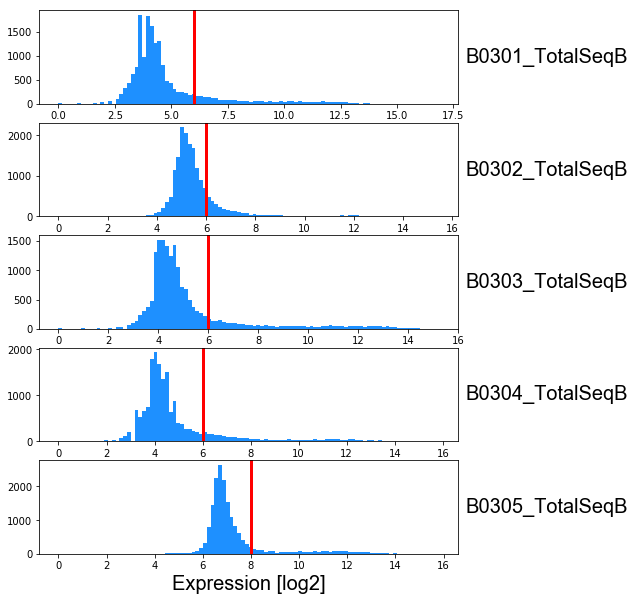

In [262]:
plot_hashes(pdH21, thr = [6,6,6,6,8])

In [263]:
hashes21 = assign_hashes(pdH21, [6,6,6,6,8])

### Add transgene counts to metadata

In [264]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [265]:
X21.obs[tgs] = X21[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [266]:
X21 = X21[:,:-8]

### Add metadata

In [267]:
X21.obs['batch'] = 'KPT_062221'
X21.obs['mouse'] = None
X21.obs['tumor'] = None
X21.obs['donor'] = None
X21.obs['treatment'] = 'untreated'
X21.obs['hash'] = hashes21
X21.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [268]:
mouse21 = {'B0301_TotalSeqB':'AJ1390',
          'B0302_TotalSeqB':'AJ1391',
          'B0303_TotalSeqB':'AJ1396',
          'B0304_TotalSeqB':'AJ1395',
          'B0305_TotalSeqB':'AJ1397'}

In [269]:
donor21 = {'B0301_TotalSeqB':'AK1471',
          'B0302_TotalSeqB':'AK1471',
          'B0303_TotalSeqB':'AK1483',
          'B0304_TotalSeqB':'AK1482',
          'B0305_TotalSeqB':'AK1483'}

In [270]:
tumor21 = {'B0301_TotalSeqB':'NSG_unsorted',
          'B0302_TotalSeqB':'NSG_unsorted',
          'B0303_TotalSeqB':'NSG_TdTom-sorted',
          'B0304_TotalSeqB':'NSG_unsorted',
          'B0305_TotalSeqB':'NSG_TdTom-sorted'}

In [271]:
X21.obs['mouse'] = [mouse21[i] if i in mouse21 else 'fail' for i in X21.obs['hash']]
X21.obs['donor'] = [donor21[i] if i in donor21 else 'fail' for i in X21.obs['hash']]
X21.obs['tumor'] = [tumor21[i] if i in tumor21 else 'fail' for i in X21.obs['hash']]

In [272]:
X21

AnnData object with n_obs × n_vars = 17467 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X22: KPT_062521

### Load AnnData

In [273]:
X22 = sc.read_10x_mtx('%s/20210901_KPT_062521_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X22.obs_names = [s.split('-')[0] for s in X22.obs_names]

In [274]:
X22.layers['raw'] = X22.X

In [275]:
H22 = X22[:,-10:]
X22 = X22[:,:-10]

### Assign hashes

In [276]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB']

In [277]:
pdH22 = sc2pd(H22, 'raw').loc[hashes]

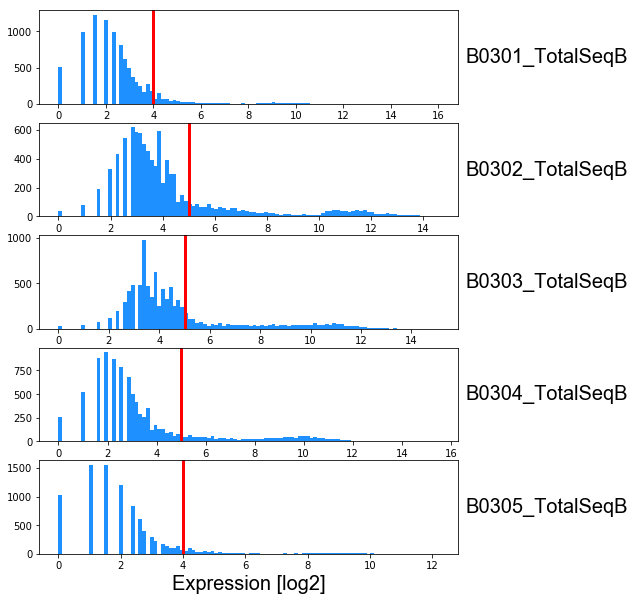

In [278]:
plot_hashes(pdH22, thr = [4,5,5,5,4])

In [279]:
hashes22 = assign_hashes(pdH22, [4,5,5,5,4])

### Add transgene counts to metadata

In [280]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [281]:
X22.obs[tgs] = X22[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [282]:
X22 = X22[:,:-8]

### Add metadata

In [283]:
X22.obs['batch'] = 'KPT_062521'
X22.obs['mouse'] = None
X22.obs['tumor'] = None
X22.obs['donor'] = None
X22.obs['treatment'] = 'untreated'
X22.obs['hash'] = hashes22
X22.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [284]:
mouse22 = {'B0301_TotalSeqB':'JC1127',
          'B0302_TotalSeqB':'JC1139',
          'B0303_TotalSeqB':'JC1140',
          'B0304_TotalSeqB':'JC1141',
          'B0305_TotalSeqB':'JC1142'}

In [285]:
donor22 = {'B0301_TotalSeqB':'AJ1511',
          'B0302_TotalSeqB':'AK1483',
          'B0303_TotalSeqB':'AK1483',
          'B0304_TotalSeqB':'AK1483',
          'B0305_TotalSeqB':'AK1483'}

In [286]:
tumor22 = {'B0301_TotalSeqB':'NSG_3D',
          'B0302_TotalSeqB':'NSG_3D',
          'B0303_TotalSeqB':'NSG_3D',
          'B0304_TotalSeqB':'F1_3D',
          'B0305_TotalSeqB':'F1_3D'}

In [287]:
X22.obs['mouse'] = [mouse22[i] if i in mouse22 else 'fail' for i in X22.obs['hash']]
X22.obs['donor'] = [donor22[i] if i in donor22 else 'fail' for i in X22.obs['hash']]
X22.obs['tumor'] = [tumor22[i] if i in tumor22 else 'fail' for i in X22.obs['hash']]

In [288]:
X22

AnnData object with n_obs × n_vars = 9260 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X23: KPT_062821

### Load AnnData

In [289]:
X23 = sc.read_10x_mtx('%s/20210901_KPT_062821_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X23.obs_names = [s.split('-')[0] for s in X23.obs_names]

In [290]:
X23.layers['raw'] = X23.X

In [291]:
H23 = X23[:,-10:]
X23 = X23[:,:-10]

### Assign hashes

In [292]:
hashes = ['B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [293]:
pdH23 = sc2pd(H23, 'raw').loc[hashes]

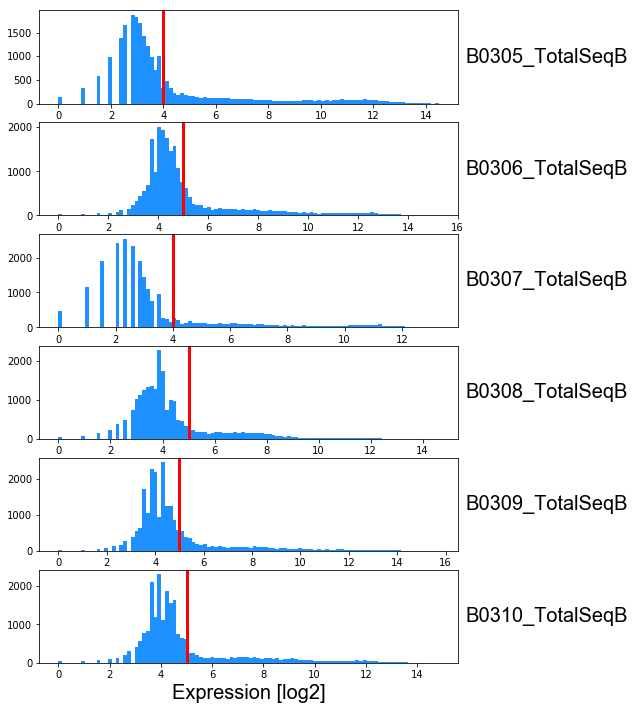

In [294]:
plot_hashes(pdH23, thr = [4,5,4,5,5,5])

In [295]:
hashes23 = assign_hashes(pdH23, [4,5,4,5,5,5])

### Add transgene counts to metadata

In [296]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [297]:
X23.obs[tgs] = X23[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [298]:
X23 = X23[:,:-8]

### Add metadata

In [299]:
X23.obs['batch'] = 'KPT_062821'
X23.obs['mouse'] = None
X23.obs['tumor'] = None
X23.obs['donor'] = None
X23.obs['treatment'] = 'untreated'
X23.obs['hash'] = hashes23
X23.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [300]:
mouse23 = {'B0305_TotalSeqB':'JC1132',
          'B0306_TotalSeqB':'AJ1393',
          'B0307_TotalSeqB':'AJ1388',
          'B0308_TotalSeqB':'AJ1389',
          'B0309_TotalSeqB':'AJ1394',
           'B0310_TotalSeqB':'AJ1398'}

In [301]:
donor23 = {'B0305_TotalSeqB':'AK1482',
          'B0306_TotalSeqB':'AK1482',
          'B0307_TotalSeqB':'AK1471',
          'B0308_TotalSeqB':'AK1471',
          'B0309_TotalSeqB':'AK1482',
           'B0310_TotalSeqB':'AK1483'}

In [302]:
tumor23 = {'B0305_TotalSeqB':'NSG_3D',
          'B0306_TotalSeqB':'NSG_TdTom-sorted',
          'B0307_TotalSeqB':'NSG_TdTom-sorted',
          'B0308_TotalSeqB':'NSG_TdTom-sorted',
          'B0309_TotalSeqB':'NSG_unsorted',
           'B0310_TotalSeqB':'NSG_unsorted'}

In [303]:
X23.obs['mouse'] = [mouse23[i] if i in mouse23 else 'fail' for i in X23.obs['hash']]
X23.obs['donor'] = [donor23[i] if i in donor23 else 'fail' for i in X23.obs['hash']]
X23.obs['tumor'] = [tumor23[i] if i in tumor23 else 'fail' for i in X23.obs['hash']]

In [304]:
X23

AnnData object with n_obs × n_vars = 22563 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X24: KPT_070721

### Load AnnData

In [305]:
X24 = sc.read_10x_mtx('%s/20210901_KPT_070721_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X24.obs_names = [s.split('-')[0] for s in X24.obs_names]

In [306]:
X24.layers['raw'] = X24.X

In [307]:
H24 = X24[:,-10:]
X24 = X24[:,:-10]

### Assign hashes

In [308]:
hashes = ['B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [309]:
pdH24 = sc2pd(H24, 'raw').loc[hashes]

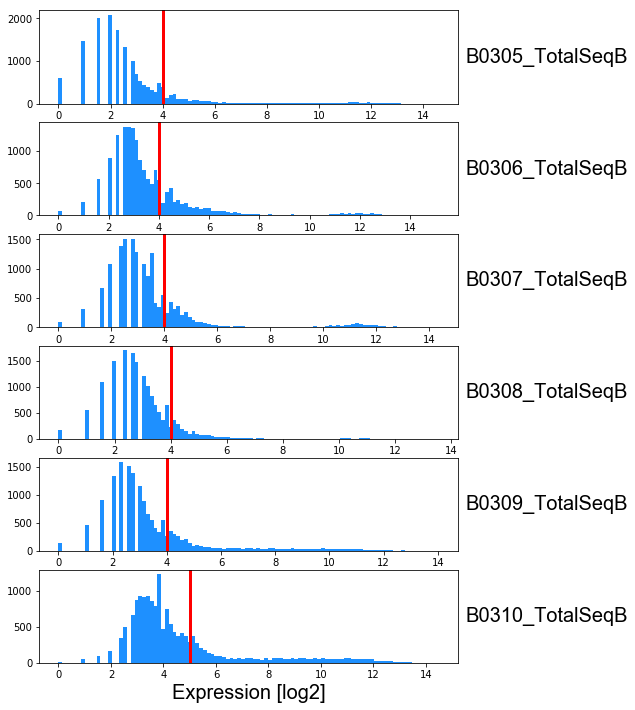

In [310]:
plot_hashes(pdH24, thr = [4,4,4,4,4,5])

In [311]:
hashes24 = assign_hashes(pdH24, [4,4,4,4,4,5])

### Add transgene counts to metadata

In [312]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [313]:
X24.obs[tgs] = X24[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [314]:
X24 = X24[:,:-8]

### Add metadata

In [315]:
X24.obs['batch'] = 'KPT_070721'
X24.obs['mouse'] = None
X24.obs['tumor'] = None
X24.obs['donor'] = None
X24.obs['treatment'] = 'untreated'
X24.obs['hash'] = hashes24
X24.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [316]:
mouse24 = {'B0305_TotalSeqB':'AK1695',
          'B0306_TotalSeqB':'AK1696',
          'B0307_TotalSeqB':'AK1697',
          'B0308_TotalSeqB':'AK1698',
          'B0309_TotalSeqB':'AK1763',
           'B0310_TotalSeqB':'AK1764'}

In [317]:
donor24 = {'B0305_TotalSeqB':'AK1483',
          'B0306_TotalSeqB':'AK1483',
          'B0307_TotalSeqB':'AK1483',
          'B0308_TotalSeqB':'AK1483',
          'B0309_TotalSeqB':'AK1483',
           'B0310_TotalSeqB':'AK1483'}

In [318]:
tumor24 = {'B0305_TotalSeqB':'NSG_fragment',
          'B0306_TotalSeqB':'NSG_fragment',
          'B0307_TotalSeqB':'NSG_2D',
          'B0308_TotalSeqB':'NSG_2D',
          'B0309_TotalSeqB':'F1_2D',
           'B0310_TotalSeqB':'F1_2D'}

In [319]:
X24.obs['mouse'] = [mouse24[i] if i in mouse24 else 'fail' for i in X24.obs['hash']]
X24.obs['donor'] = [donor24[i] if i in donor24 else 'fail' for i in X24.obs['hash']]
X24.obs['tumor'] = [tumor24[i] if i in tumor24 else 'fail' for i in X24.obs['hash']]

In [320]:
X24

AnnData object with n_obs × n_vars = 15915 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X25: KPT_071221

### Load AnnData

In [321]:
X25 = sc.read_10x_mtx('%s/20210901_KPT_071221_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X25.obs_names = [s.split('-')[0] for s in X25.obs_names]

In [322]:
X25.layers['raw'] = X25.X

In [323]:
H25 = X25[:,-10:]
X25 = X25[:,:-10]

### Assign hashes

In [324]:
hashes = ['B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [325]:
pdH25 = sc2pd(H25, 'raw').loc[hashes]

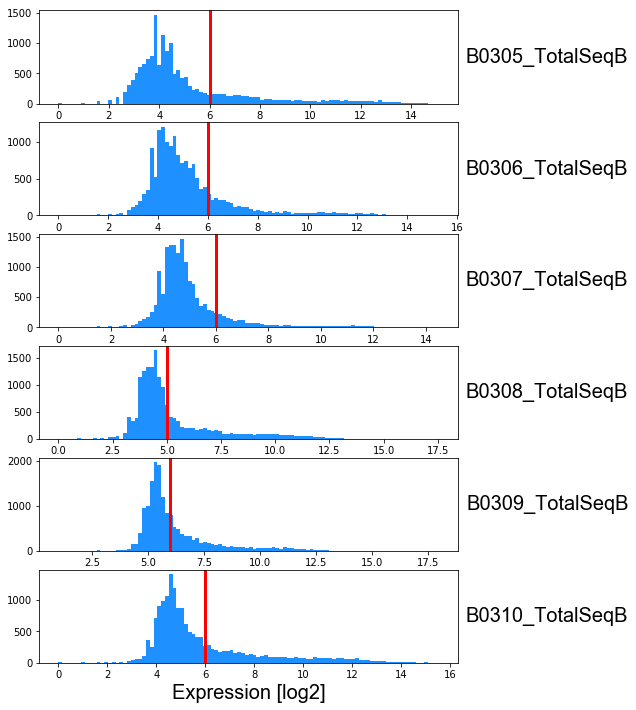

In [326]:
plot_hashes(pdH25, thr = [6,6,6,5,6,6])

In [327]:
hashes25 = assign_hashes(pdH25, [6,6,6,5,6,6])

### Add transgene counts to metadata

In [328]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [329]:
X25.obs[tgs] = X25[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [330]:
X25 = X25[:,:-8]

### Add metadata

In [331]:
X25.obs['batch'] = 'KPT_071221'
X25.obs['mouse'] = None
X25.obs['tumor'] = None
X25.obs['donor'] = None
X25.obs['treatment'] = 'untreated'
X25.obs['hash'] = hashes25
X25.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [332]:
mouse25 = {'B0305_TotalSeqB':'AK1694',
          'B0306_TotalSeqB':'AK1754',
          'B0307_TotalSeqB':'AK1755',
          'B0308_TotalSeqB':'AK1762',
          'B0309_TotalSeqB':'AK1765',
           'B0310_TotalSeqB':'AK1770'}

In [333]:
donor25 = {'B0305_TotalSeqB':'AK1482',
          'B0306_TotalSeqB':'AJ1511',
          'B0307_TotalSeqB':'AJ1511',
          'B0308_TotalSeqB':'AK1483',
          'B0309_TotalSeqB':'AK1483',
           'B0310_TotalSeqB':'AJ1511'}

In [334]:
tumor25 = {'B0305_TotalSeqB':'NSG_2D',
          'B0306_TotalSeqB':'NSG_2D',
          'B0307_TotalSeqB':'NSG_2D',
          'B0308_TotalSeqB':'F1_2D',
          'B0309_TotalSeqB':'F1_2D',
           'B0310_TotalSeqB':'F1_2D'}

In [335]:
X25.obs['mouse'] = [mouse25[i] if i in mouse25 else 'fail' for i in X25.obs['hash']]
X25.obs['donor'] = [donor25[i] if i in donor25 else 'fail' for i in X25.obs['hash']]
X25.obs['tumor'] = [tumor25[i] if i in tumor25 else 'fail' for i in X25.obs['hash']]

In [336]:
X25

AnnData object with n_obs × n_vars = 16410 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X26: KPT_072021

### Load AnnData

In [337]:
X26 = sc.read_10x_mtx('%s/20211001_KPT_072021_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X26.obs_names = [s.split('-')[0] for s in X26.obs_names]

In [338]:
X26.layers['raw'] = X26.X

In [339]:
H26 = X26[:,-10:]
X26 = X26[:,:-10]

### Assign hashes

In [340]:
hashes = ['B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB']

In [341]:
pdH26 = sc2pd(H26, 'raw').loc[hashes]

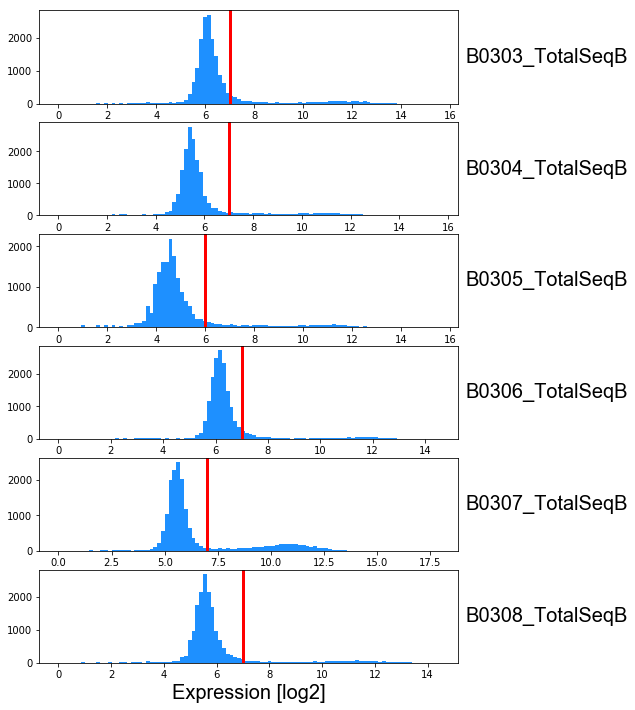

In [342]:
plot_hashes(pdH26, thr = [7,7,6,7,7,7])

In [343]:
hashes26 = assign_hashes(pdH26, [7,7,6,7,7,7])

### Add transgene counts to metadata

In [344]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [345]:
X26.obs[tgs] = X26[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [346]:
X26 = X26[:,:-8]

### Add metadata

In [347]:
X26.obs['batch'] = 'KPT_072021'
X26.obs['mouse'] = None
X26.obs['tumor'] = None
X26.obs['donor'] = None
X26.obs['treatment'] = 'untreated'
X26.obs['hash'] = hashes26
X26.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [348]:
mouse26 = {'B0303_TotalSeqB':'JC1137',
          'B0304_TotalSeqB':'AK1751',
          'B0305_TotalSeqB':'AK1752',
          'B0306_TotalSeqB':'AK1756',
          'B0307_TotalSeqB':'AK1758',
           'B0308_TotalSeqB':'AH1872'}

In [349]:
donor26 = {'B0303_TotalSeqB':'AK1482',
          'B0304_TotalSeqB':'AK1471',
          'B0305_TotalSeqB':'AK1471',
          'B0306_TotalSeqB':'AK1482',
          'B0307_TotalSeqB':'AK1482',
           'B0308_TotalSeqB':'AK1483'}

In [350]:
tumor26 = {'B0303_TotalSeqB':'NSG_3D',
          'B0304_TotalSeqB':'NSG_fragment',
          'B0305_TotalSeqB':'NSG_fragment',
          'B0306_TotalSeqB':'F1_fragment',
          'B0307_TotalSeqB':'F1_2D',
           'B0308_TotalSeqB':'F1_unsorted'}

In [351]:
X26.obs['mouse'] = [mouse26[i] if i in mouse26 else 'fail' for i in X26.obs['hash']]
X26.obs['donor'] = [donor26[i] if i in donor26 else 'fail' for i in X26.obs['hash']]
X26.obs['tumor'] = [tumor26[i] if i in tumor26 else 'fail' for i in X26.obs['hash']]

In [352]:
X26

AnnData object with n_obs × n_vars = 17694 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X27: OG-1221_KPT_081021

### Load AnnData

In [353]:
X27 = sc.read_10x_mtx('%s/20211022_OG-1221_KPT_081021_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X27.obs_names = [s.split('-')[0] for s in X27.obs_names]

In [354]:
X27.layers['raw'] = X27.X

In [355]:
H27 = X27[:,-10:]
X27 = X27[:,:-10]

### Assign hashes

In [356]:
hashes = ['B0301_TotalSeqB',
          'B0304_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [357]:
pdH27 = sc2pd(H27, 'raw').loc[hashes]

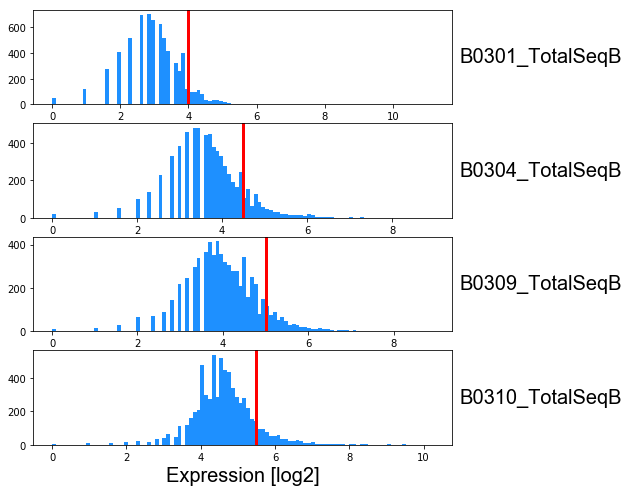

In [358]:
plot_hashes(pdH27, thr = [4,4.5,5,5.5])

In [359]:
hashes27 = assign_hashes(pdH27, [4,4.5,5,5.5])

### Add transgene counts to metadata

In [360]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [361]:
X27.obs[tgs] = X27[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [362]:
X27 = X27[:,:-8]

### Add metadata

In [363]:
X27.obs['batch'] = 'OG-1221_KPT_081021'
X27.obs['mouse'] = None
X27.obs['tumor'] = None
X27.obs['donor'] = None
X27.obs['treatment'] = 'untreated'
X27.obs['hash'] = hashes27
X27.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [364]:
mouse27 = {'B0301_TotalSeqB':'JC1133',
           'B0304_TotalSeqB':'AK1759',
           'B0309_TotalSeqB':'AK1768',
           'B0310_TotalSeqB':'AK1769'}

In [365]:
donor27 = {'B0301_TotalSeqB':'AK1482',
           'B0304_TotalSeqB':'AK1482',
           'B0309_TotalSeqB':'AJ1511',
           'B0310_TotalSeqB':'AJ1511'}

In [366]:
tumor27 = {'B0301_TotalSeqB':'NSG_3D',
           'B0304_TotalSeqB':'F1_2D',
           'B0309_TotalSeqB':'F1_2D',
           'B0310_TotalSeqB':'F1_2D'}

In [367]:
X27.obs['mouse'] = [mouse27[i] if i in mouse27 else 'fail' for i in X27.obs['hash']]
X27.obs['donor'] = [donor27[i] if i in donor27 else 'fail' for i in X27.obs['hash']]
X27.obs['tumor'] = [tumor27[i] if i in tumor27 else 'fail' for i in X27.obs['hash']]

In [368]:
X27

AnnData object with n_obs × n_vars = 6724 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X28: OG-1331_Day3_100621

### Load AnnData

In [369]:
X28 = sc.read_10x_mtx('%s/20211108_OG-1331_Day3_100621_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X28.obs_names = [s.split('-')[0] for s in X28.obs_names]

In [370]:
X28.layers['raw'] = X28.X

In [371]:
H28 = X28[:,-10:]
X28 = X28[:,:-10]

### Assign hashes

In [372]:
hashes = ['B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB']

In [373]:
pdH28 = sc2pd(H28, 'raw').loc[hashes]

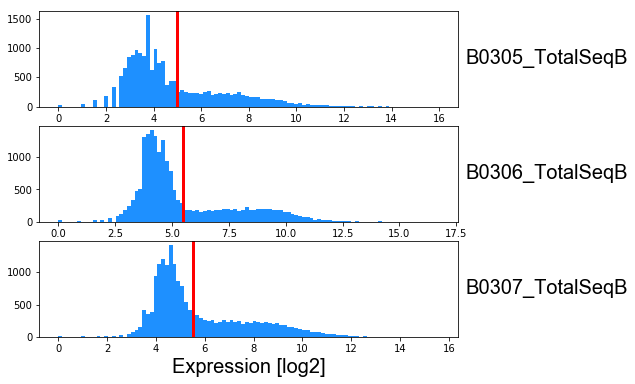

In [374]:
plot_hashes(pdH28, thr = [5,5.5,5.5])

In [375]:
hashes28 = assign_hashes(pdH28, [5,5.5,5.5])

### Add transgene counts to metadata

In [376]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [377]:
X28.obs[tgs] = X28[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [378]:
X28 = X28[:,:-8]

### Add metadata

In [379]:
X28.obs['batch'] = 'OG-1331_Day3_100621'
X28.obs['mouse'] = None
X28.obs['tumor'] = 'autochthonous'
X28.obs['donor'] = 'None'
X28.obs['treatment'] = '3d_TAM'
X28.obs['hash'] = hashes28
X28.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [380]:
mouse28  = {'B0305_TotalSeqB':'AN1928',
            'B0306_TotalSeqB':'AO1213',
            'B0307_TotalSeqB':'AO1235'}

In [381]:
X28.obs['mouse'] = [mouse28[i] if i in mouse28 else 'fail' for i in X28.obs['hash']]

In [382]:
X28

AnnData object with n_obs × n_vars = 18534 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## X29: AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag

### Load AnnData

In [22]:
X29 = sc.read_10x_mtx('%s/20211108_AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
X29.obs_names = [s.split('-')[0] for s in X29.obs_names]

In [23]:
X29.layers['raw'] = X29.X

In [24]:
H29 = X29[:,-10:]
X29 = X29[:,:-10]

### Assign hashes

In [25]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB']

In [26]:
pdH29 = sc2pd(H29, 'raw').loc[hashes]

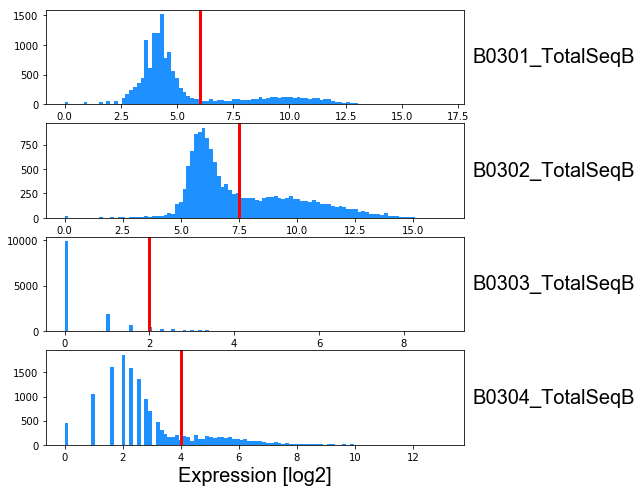

In [27]:
plot_hashes(pdH29, thr = [6,7.5,2,4])

In [28]:
hashes29 = assign_hashes(pdH29, [6,7.5,2,4])

### Add transgene counts to metadata

In [29]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [30]:
X29.obs[tgs] = X29[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [31]:
X29 = X29[:,:-8]

### Add metadata

In [393]:
X29.obs['batch'] = 'AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag'
X29.obs['mouse'] = None
X29.obs['tumor'] = None
X29.obs['donor'] = None
X29.obs['treatment'] = '10d_TAM'
X29.obs['hash'] = hashes29
X29.obs['10X_version'] = 'v3'

Trying to set attribute `.obs` of view, copying.


In [394]:
mouse29  = {'B0301_TotalSeqB':'AN1185',
            'B0302_TotalSeqB':'AN1187',
            'B0303_TotalSeqB':'AN1332',
            'B0304_TotalSeqB':'AK1691'}

In [395]:
donor29  = {'B0301_TotalSeqB':'None',
            'B0302_TotalSeqB':'None',
            'B0303_TotalSeqB':'None',
            'B0304_TotalSeqB':'AK1482'}

In [396]:
tumor29 = {'B0301_TotalSeqB':'autochthonous',
           'B0302_TotalSeqB':'autochthonous',
           'B0303_TotalSeqB':'autochthonous',
           'B0304_TotalSeqB':'NSG_fragment'}

In [397]:
X29.obs['mouse'] = [mouse29[i] if i in mouse29 else 'fail' for i in X29.obs['hash']]
X29.obs['donor'] = [donor29[i] if i in donor29 else 'fail' for i in X29.obs['hash']]
X29.obs['tumor'] = [tumor29[i] if i in tumor29 else 'fail' for i in X29.obs['hash']]

In [398]:
X29

AnnData object with n_obs × n_vars = 14508 × 54838
    obs: 'FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT', 'LoxP', 'mScarlet', 'Ova', 'batch', 'mouse', 'tumor', 'donor', 'treatment', 'hash', '10X_version'
    var: 'gene_ids', 'feature_types'
    layers: 'raw'

## Concatenate

In [399]:
X = X1.concatenate(X2,
                   X3,
                   X4,
                   X5,
                   X6,
                   X7,
                   X8,
                   X9,
                   X10,
                   X11,
                   X12,
                   X13,
                   X14,
                   X15,
                   X16,
                   X17,
                   X18,
                   X19,
                   X20,
                   X21,
                   X22,
                   X23,
                   X24,
                   X25,
                   X26,
                   X27,
                   X28,
                   X29,
                   batch_key='concat', 
                   index_unique='-',
                   join='inner')

In [400]:
X.layers['raw'] = X.X

In [401]:
#X.X = X.X.todense()

In [402]:
np.shape(X)

(285357, 54838)

## Checkpoint

In [403]:
X.write_h5ad('%s/%s_PDAC_Lgr5_raw.h5' % (path_output, exp_id))

... storing 'batch' as categorical
... storing 'mouse' as categorical
... storing 'tumor' as categorical
... storing 'donor' as categorical
... storing 'treatment' as categorical
... storing 'hash' as categorical
... storing '10X_version' as categorical
... storing 'feature_types' as categorical


# Pre-processing - filtering

In [15]:
X = sc.read_h5ad('%s/%s_PDAC_Lgr5_raw.h5' % (path_output, exp_id))

## Calculate QC metrics

In [405]:
X.var['mito'] = list(map(lambda x: x[:3] == 'mt-', X.var_names))

In [406]:
sc.pp.calculate_qc_metrics(X, qc_vars = ['mito'], inplace = True)

## Plot sample specific yields

In [23]:
def QC_hist_v1(anndata, 
               param, 
               groups, 
               cmap_groups=plt.cm.tab20, 
               xlim=(0,25000), 
               log=False, 
               thr=None, 
               gr_order=None,
               **kwargs):
    
    #compile data based on param
    
    assert param in anndata.obs.columns, '"param" not found in data.obs'
    
    data = anndata.obs[param]
        
    if log:
        data = np.log10(data+1)
        xlim = (np.log10(xlim[0]+1),np.log10(xlim[1]+1))
        if thr:
            thr = np.log10(thr+1)
            
    #define group order
    
    assert groups in anndata.obs.columns, '"groups" not found in data.obs'
    
    groups = anndata.obs[groups]
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    #initialize figure
    
    l = len(set(groups))

    height = 2 * l
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(l, 1, hspace=0)
    
    #get colormap
    
    if type(cmap_groups) != dict:
        cm = cmap_groups
        cmap = {}
        for i, b in enumerate(set(groups)):
            cmap[b] = cm(float(i) / 20)
            
    else:
        cmap = cmap_groups
    
    #plot groups
    
    for i, b in enumerate(gr_order):
        
        ax = plt.subplot(gs[i])
        
        ax.set_xlim(xlim)
        
        if i == l-1:
            ax.set_xlabel(param)
                
        else:
            ax.set_xticks([])
                
        ax.set_ylabel('Number of cells')
        
        i_tmp = groups[groups==b].index
        
        ax.hist(data[i_tmp],
            bins=100,
            color=cmap[b],
            range = xlim,
            **kwargs)
        
        if thr:
            ax.axvline(thr, color = 'red', linestyle = '-', linewidth = 3)
        ax.axvline(np.median(data[i_tmp]), color = 'black', linestyle = '-', linewidth = 3)
        ax.axvline(np.percentile(data[i_tmp], 5), color = 'black', linestyle = '--', linewidth = 2)
        ax.axvline(np.percentile(data[i_tmp], 95), color = 'black', linestyle = '--', linewidth = 2)
        ax.axvline(np.percentile(data[i_tmp], 1), color = 'black', linestyle = ':', linewidth = 2)
        ax.axvline(np.percentile(data[i_tmp], 99), color = 'black', linestyle = ':', linewidth = 2)
        
        ax.text(ax.get_xlim()[1] * 1.01, ax.get_ylim()[1] * 0.5, b, family = 'Arial', fontsize = 15, ha = 'left', va = 'center')

In [408]:
pdX = sc2pd(X, 'raw')

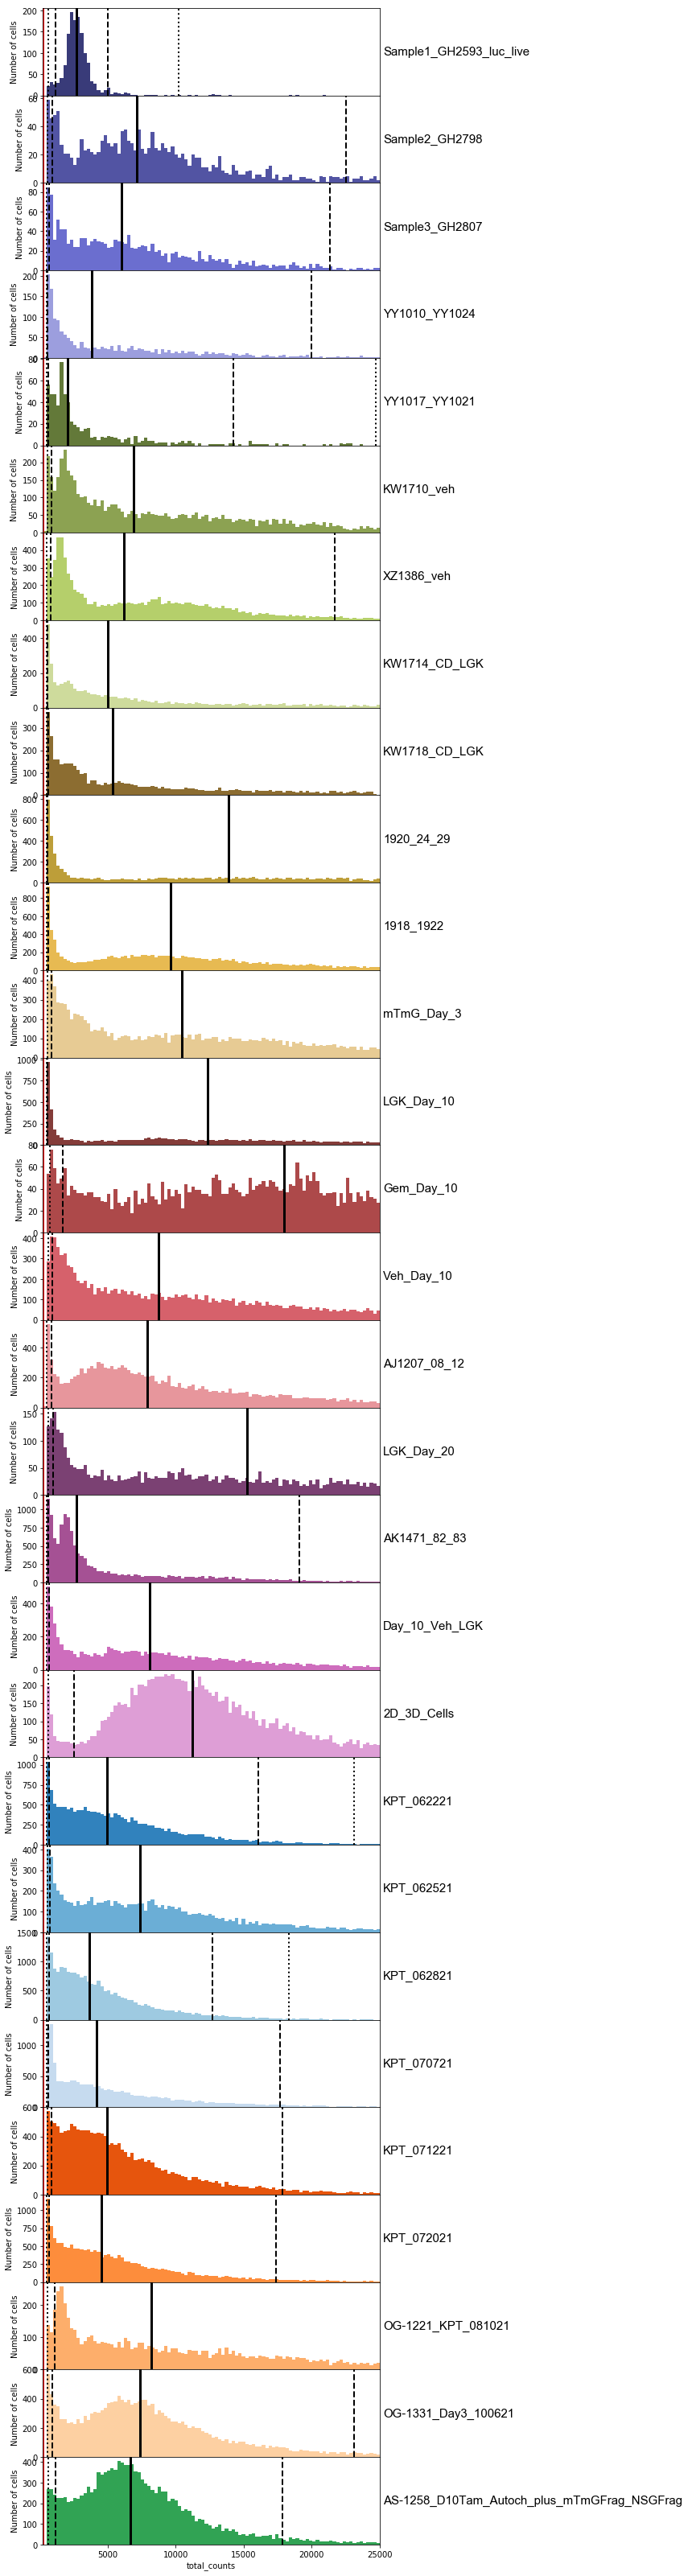

In [409]:
QC_hist_v1(X,
           'total_counts',
           'batch',
           cmap_groups={g:plt.cm.tab20b(i/20) if i<20 else plt.cm.tab20c((i-20)/20) for i, g in enumerate(return_unique(X.obs['batch']))},
           xlim=(250,25000), 
           thr = 200)

## Remove cells with less than 500 UMIs

In [410]:
c_sel = X.obs[X.obs['total_counts']>=500].index

In [411]:
len(c_sel)

285297

In [412]:
X = X[c_sel]

## Remove cells with more than 20% mitochondrial reads

In [413]:
c_sel = X.obs[X.obs['pct_counts_mito']<20].index

In [414]:
len(c_sel)

264005

In [415]:
X = X[c_sel]

## Remove potential doublets

In [416]:
c_sel = X.obs[X.obs['mouse']!='fail'].index

In [417]:
len(c_sel)

175745

In [418]:
X = X[c_sel]

## Remove low complexity / abundance cells

Trying to set attribute `.obs` of view, copying.


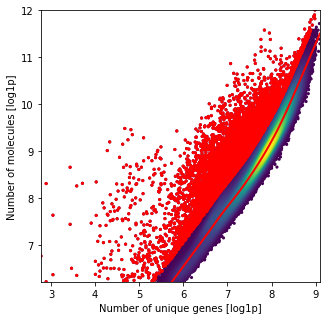

In [419]:
calculate_complexity(X, res_thr = 0.5, lowess_frac = 0.3)

In [420]:
c_sel = X.obs[X.obs['complexity_res']<0.5].index

In [421]:
len(c_sel)

167754

In [422]:
X = X[c_sel]

## Checkpoint

In [423]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

# Pre-processing - exploratory clustering of raw data

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [16]:
#X.X = X.X.todense()

## log2 transformation

In [17]:
X.layers['raw_log2'] = scipy.sparse.csr_matrix(np.log2(X.X.todense()+1))

In [18]:
#X.X = X.layers['raw_log2'].todense()

## Feature selection - gene filtering

In [19]:
g_sel = X.var[(X.var['mean_counts']>0.1) & (X.var['n_cells_by_counts']>(len(X.obs_names)*0.1))].index

In [20]:
len(g_sel)

7900

In [21]:
Xs = X[:,g_sel]

## Feature selection - VST

In [22]:
feat = select_features_vst(sc2pd(Xs, 'raw'), 5000)

In [23]:
Xs = Xs[:,feat]

## Dimensionality reduction - NMF

In [24]:
pdX = sc2pd(Xs, 'raw_log2')

In [25]:
nmf = dim_reduc(pdX, dim=50, method='NMF')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [26]:
Xs.obsm['X_nmf'] = np.array(nmf).T

## k-nearest neighbors

In [27]:
sc.pp.neighbors(Xs, n_neighbors=25, n_pcs=50, use_rep='X_nmf', metric='euclidean')

## UMAP

In [28]:
sc.tl.umap(Xs, min_dist=0.5, spread=5)

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


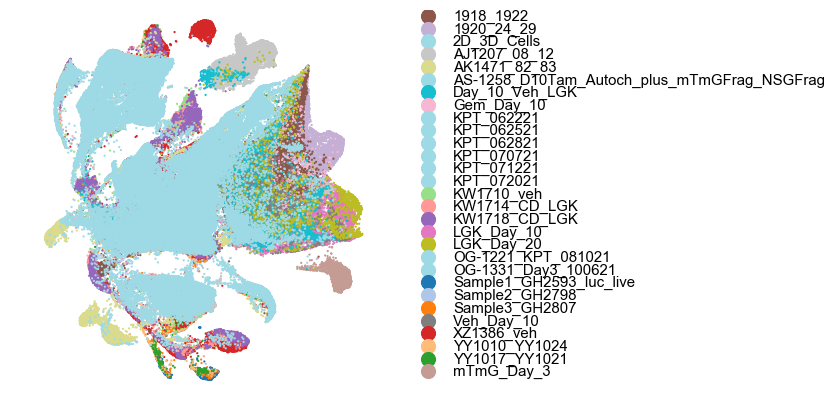

In [29]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['batch'],
                    s=5, show_axes=False)

In [30]:
pdX = sc2pd(Xs, 'raw_log2')

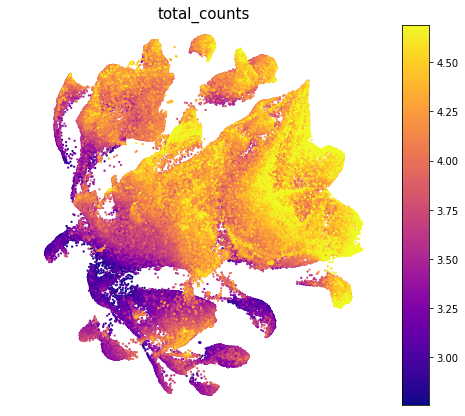

In [31]:
expr = np.log10(Xs.obs['total_counts']+1)
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  cmap=plt.cm.plasma,
                  text = 'total_counts',
                  s = 5, show_axes=False)

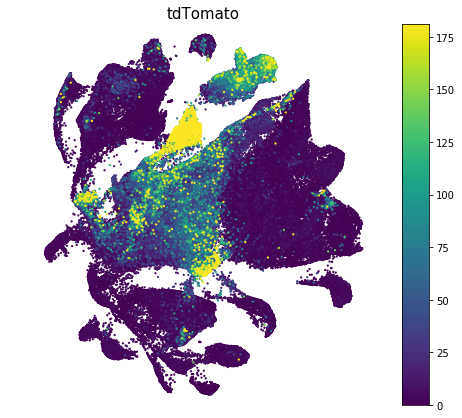

In [32]:
g = 'tdTomato'
expr = Xs.obs[g]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

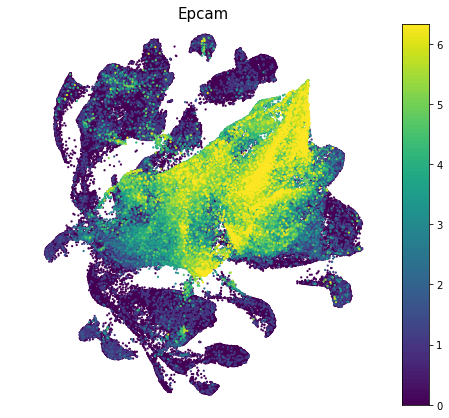

In [33]:
g = 'Epcam'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

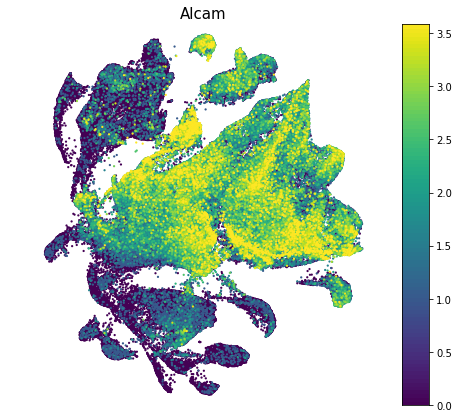

In [34]:
g = 'Alcam'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

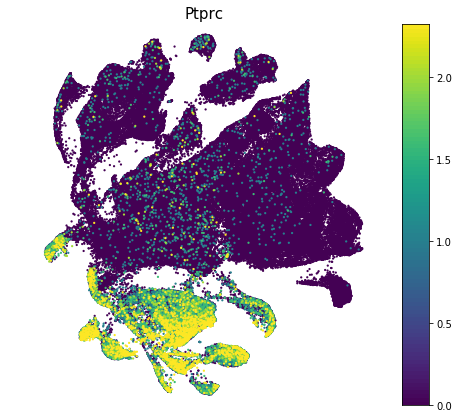

In [35]:
g = 'Ptprc'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

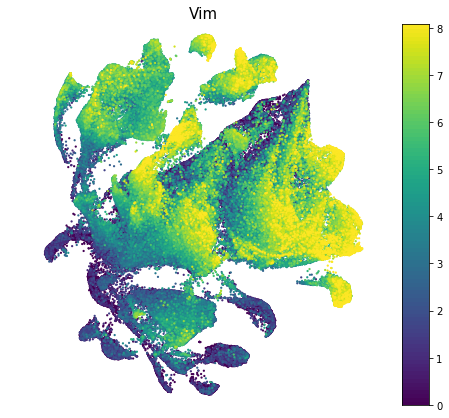

In [36]:
g = 'Vim'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

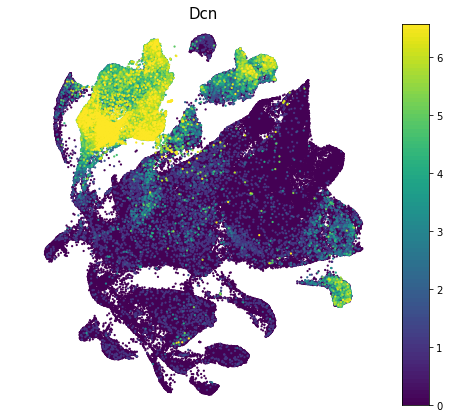

In [37]:
g = 'Dcn'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

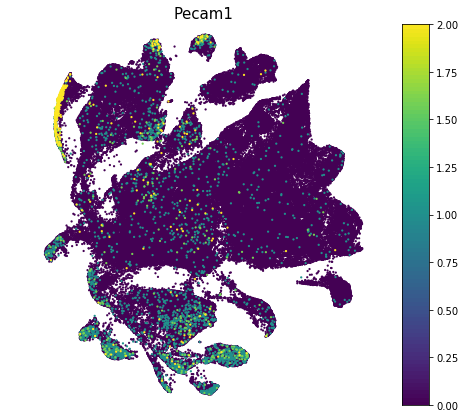

In [38]:
g = 'Pecam1'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  0,
                  2,
                  text = g,
                  s = 5, show_axes=False)

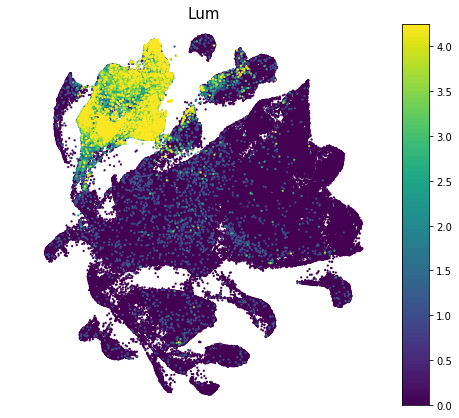

In [39]:
g = 'Lum'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

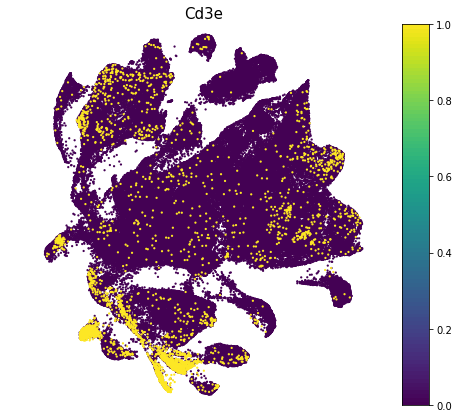

In [40]:
g = 'Cd3e'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

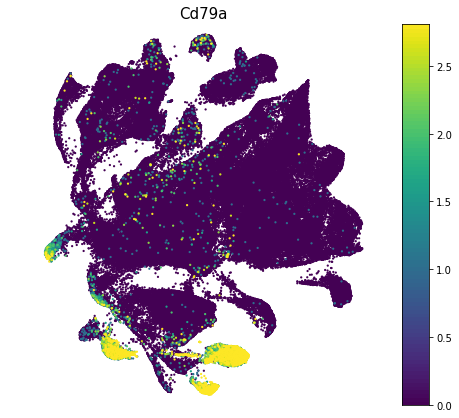

In [41]:
g = 'Cd79a'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

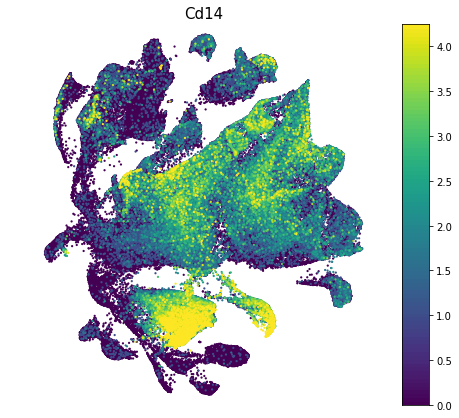

In [42]:
g = 'Cd14'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

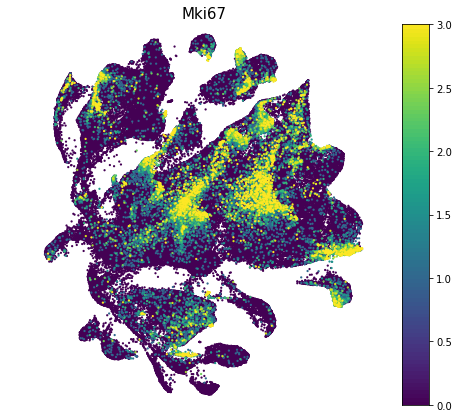

In [43]:
g = 'Mki67'
expr = sc2pd(X, 'raw_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering

In [44]:
sc.tl.leiden(Xs, resolution = 0.2)

In [45]:
len(set(Xs.obs['leiden']))

13

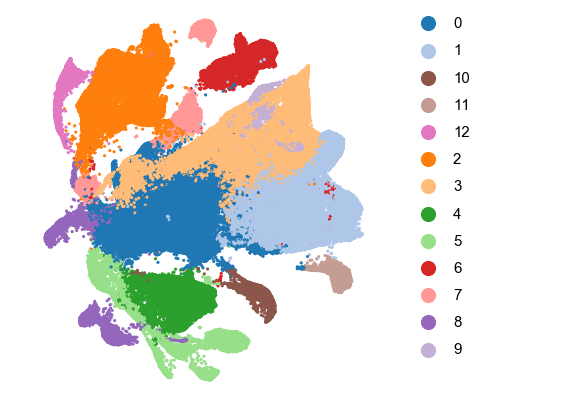

In [46]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['leiden'],
                    cmap_tab20,
                    s=10, show_axes=False)

In [47]:
cl_pp = pd.Series('EPI', index=Xs.obs_names)

# combine lymphoid cells

cl_pp[Xs.obs['leiden'][Xs.obs['leiden'].isin(['5','8'])].index] = 'IMM-LY'

# combine myeloid cells

cl_pp[Xs.obs['leiden'][Xs.obs['leiden'].isin(['4','10'])].index] = 'IMM-MY'

# combine fibroblasts

cl_pp[Xs.obs['leiden'][Xs.obs['leiden'].isin(['2'])].index] = 'FIB'

# combine endothelial cells

cl_pp[Xs.obs['leiden'][Xs.obs['leiden'].isin(['12'])].index] = 'ENDO'

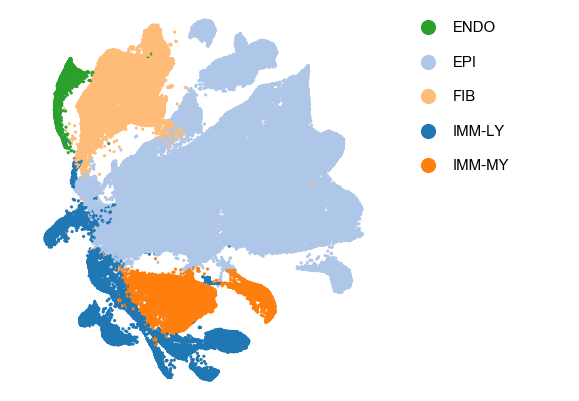

In [48]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    cl_pp,
                    s=10, show_axes=False)

In [49]:
X.obs['cl_pp'] = cl_pp
X.obsm['X_umap_pp'] = Xs.obsm['X_umap']

## Checkpoint

In [50]:
X.X = scipy.sparse.csr_matrix(X.X)

In [51]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

... storing 'cl_pp' as categorical


# Pre-processing - local filtering

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [16]:
pdX = sc2pd(X, 'raw')

## Total UMI distribution in clusters

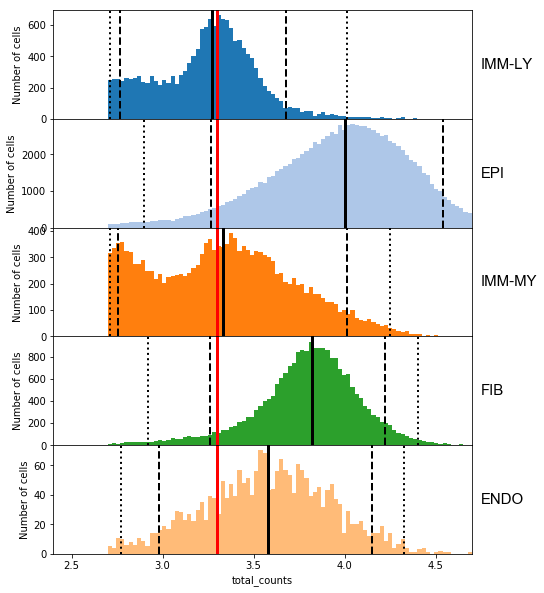

In [18]:
QC_hist_v1(X,
           'total_counts',
           'cl_pp',
           log=True, xlim=(250,50000), thr=2000)

## Remove epithelial cells with less than 2000 unique reads

In [19]:
c_EPI = X.obs['cl_pp'][X.obs['cl_pp'].isin(['EPI'])].index

In [20]:
len(c_EPI)

111944

In [21]:
c_sel_EPI = X.obs['total_counts'][c_EPI][X.obs['total_counts'][c_EPI]>2000].index

## Remove other cells with less than 1000 unique reads

In [22]:
c_other = X.obs['cl_pp'][~X.obs['cl_pp'].isin(['EPI'])].index

In [23]:
len(c_other)

55810

In [25]:
c_sel_other = X.obs['total_counts'][c_other][X.obs['total_counts'][c_other]>1000].index

## Apply filter

In [27]:
c_sel = list(c_sel_EPI) + list(c_sel_other)

In [28]:
len(c_sel)

153724

In [29]:
X = X[c_sel]

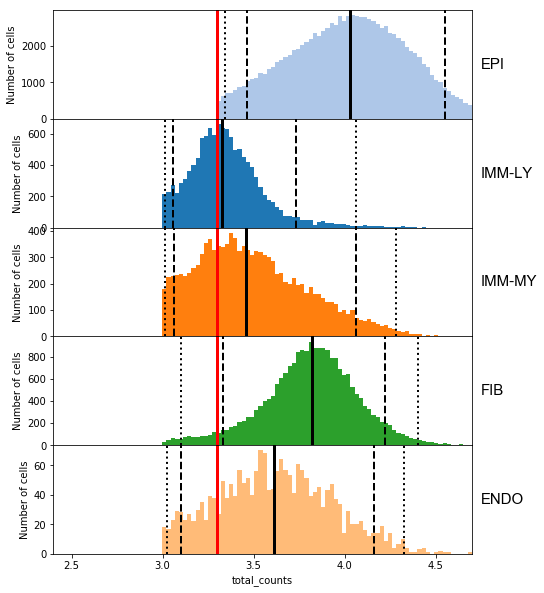

In [30]:
QC_hist_v1(X,
           'total_counts',
           'cl_pp',
           log=True, xlim=(250,50000), thr=2000)

## Checkpoint

In [31]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

# Pre-processing: Filter doublets with scrublet (Wolock et al. 2019)

In [32]:
import scrublet as scr

In [33]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

## Flag doublets

In [34]:
pdX = sc2pd(X, 'raw_log2')

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.7%
Elapsed time: 10.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 19.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 27.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.2%
Elapsed time: 10.9 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 4.1%
Estimated detectable doublet fraction = 51.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 14.3 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 29.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 3.9 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 9.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 2.0 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 40.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.0%
Elapsed time: 11.9 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 4.1%
Estimated detectable doublet fraction = 62.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.6%
Elapsed time: 14.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 47.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.6%
Elapsed time: 13.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 35.9 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 6.6 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 26.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 1.8 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 14.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 8.0 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 18.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 0.6 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 40.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.2%
Elapsed time: 22.8 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 28.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 5.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 34.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.2%
Elapsed time: 6.6 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 4.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 26.2 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 6.8%
Estimated detectable doublet fraction = 48.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.0%
Elapsed time: 1.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 12.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 1.5 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 45.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 14.7 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...
Simulating doublets...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 43.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 0.7 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 37.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 9.0 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 35.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 16.7 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 31.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 17.5 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 31.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.7%
Elapsed time: 8.5 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 30.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 4.7 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 10.8 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 13.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 10.1 seconds


/Users/simjoo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

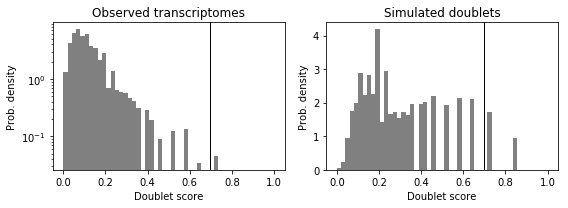

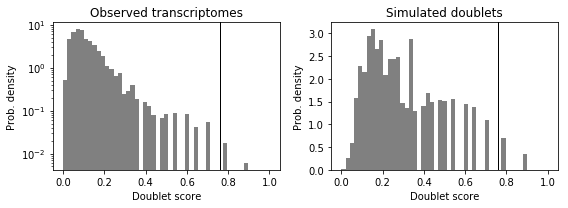

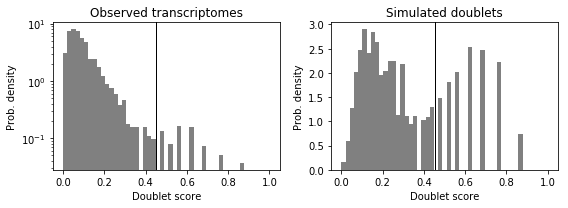

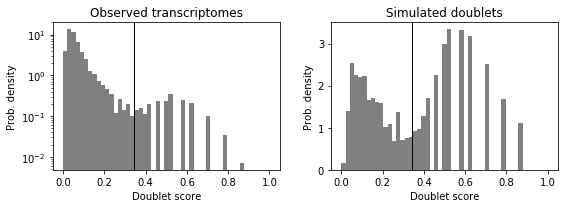

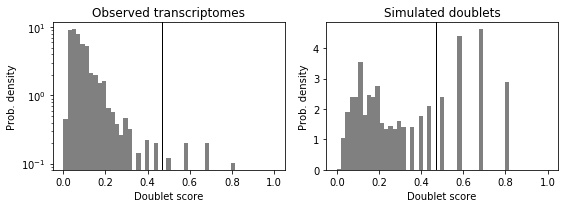

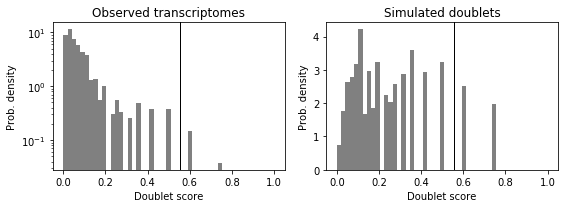

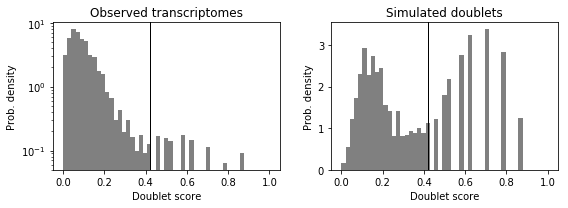

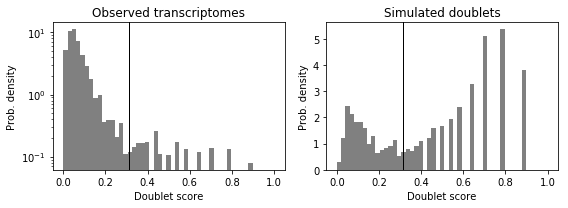

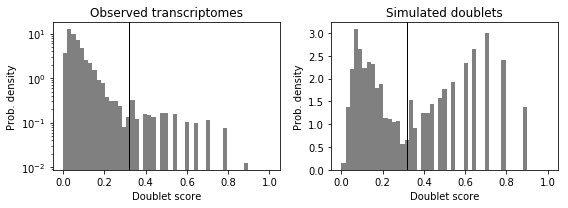

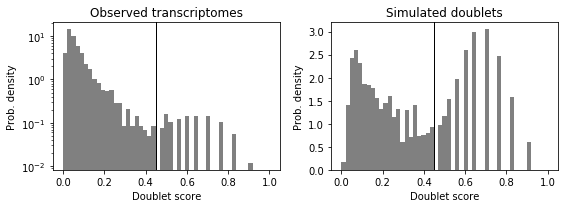

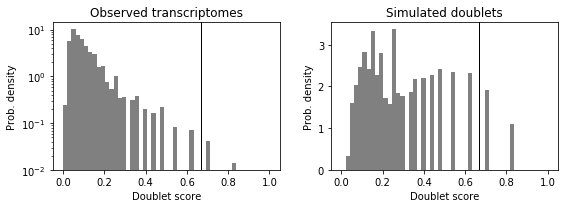

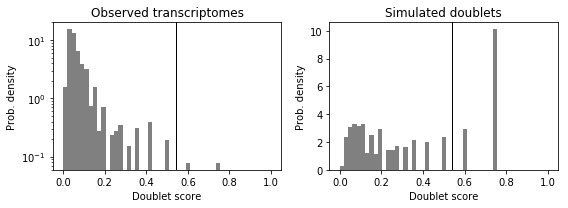

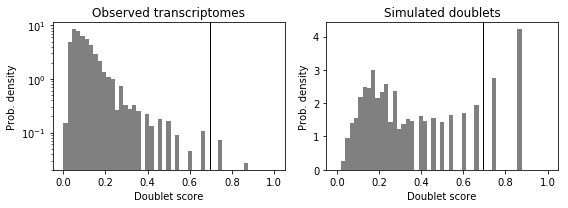

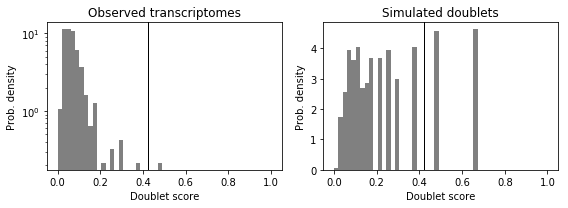

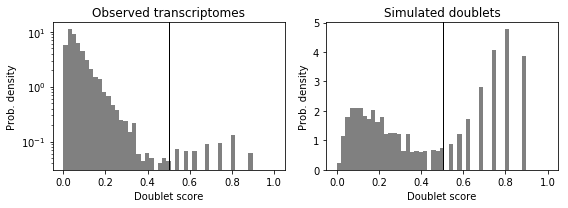

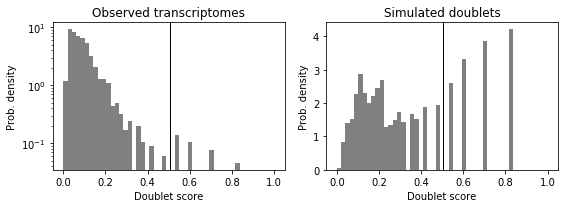

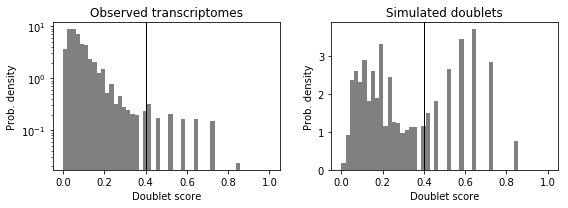

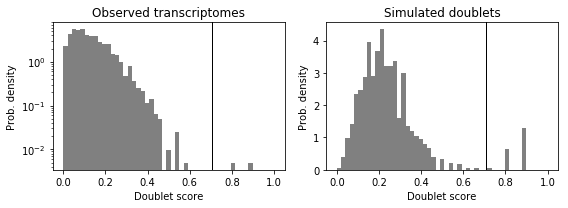

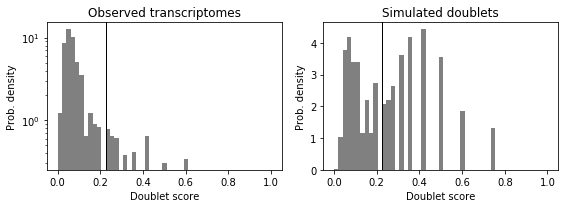

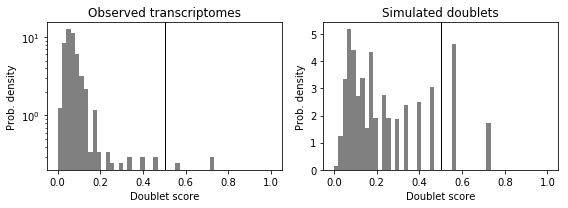

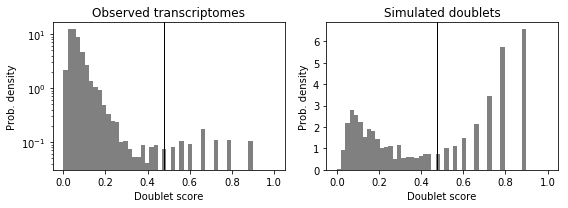

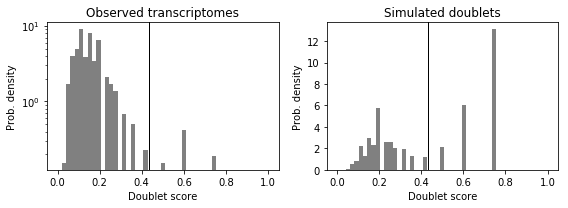

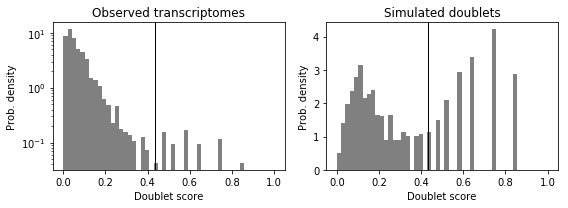

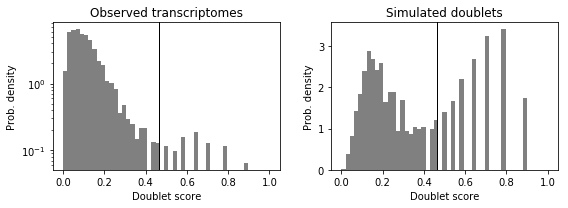

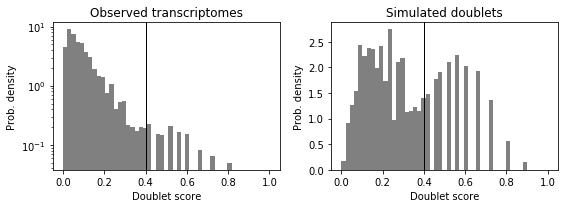

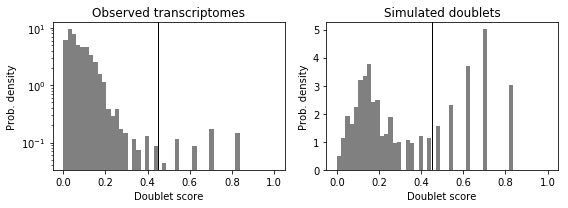

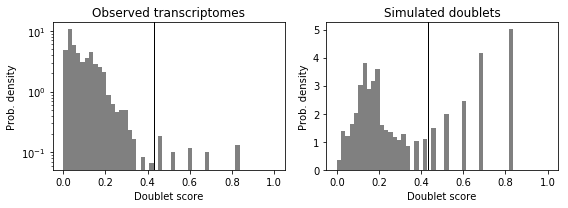

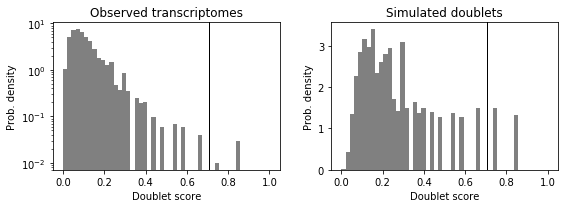

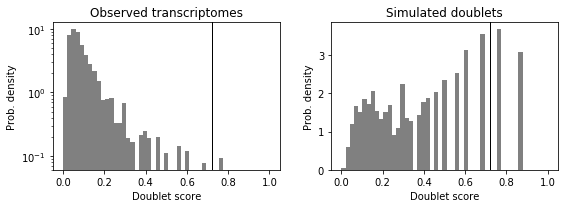

In [35]:
X.obs['doublet_scores'] = None

for b in set(X.obs['batch']):
    c_sel = X.obs['batch'][X.obs['batch']==b].index
    scrub = scr.Scrublet(pdX[c_sel].T)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    scrub.plot_histogram()
    X.obs['doublet_scores'][c_sel] = doublet_scores

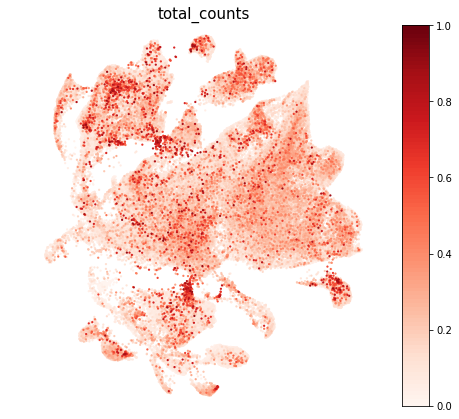

In [36]:
expr = X.obs['doublet_scores']
draw_scatter_expr(X[pdX.columns].obsm['X_umap_pp'],
                  expr,
                  0,
                  1,
                  cmap=plt.cm.Reds,
                  text = 'total_counts',
                  s = 5, show_axes=False)

In [37]:
X.obs['doublets'] = X.obs['doublet_scores'] > 0.4

In [38]:
Counter(X.obs['doublets'])

Counter({False: 150699, True: 3025})

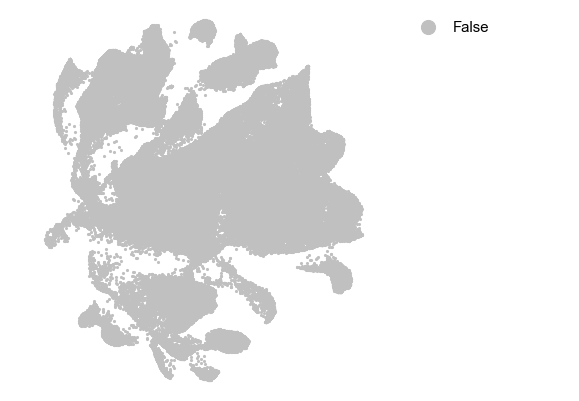

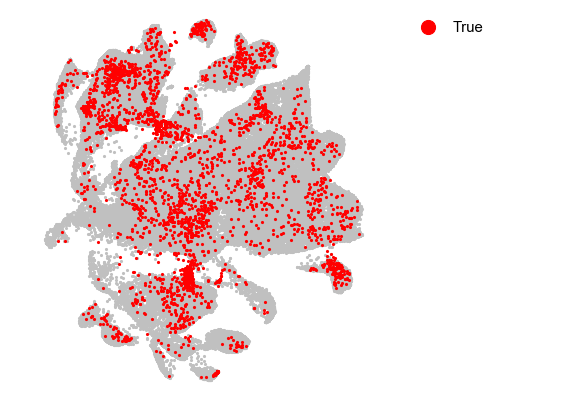

In [39]:
draw_scatter_groups_individual(X.obsm['X_umap_pp'], 
                    X.obs['doublets'],
                    cmap={False:'silver',True:'red'},
                    s=10,show_axes=False)

## Filter doublets

In [40]:
c_sel = X.obs['doublets'][X.obs['doublets']==False].index

In [41]:
len(c_sel)

150699

In [42]:
X = X[c_sel]

## Checkpoint

In [43]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'doublet_scores' as categorical


# Pre-processing: Size factor normalization (Lun method)

In [44]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

## Filter genes (mean expression: 0.1 molecules, expressed in at least 10% of cells)

In [45]:
g_sel = X.var[(X.var['mean_counts']>0.1) & (X.var['n_cells_by_counts']>(len(X.obs_names)*0.1))].index

In [46]:
len(g_sel)

7935

In [47]:
Xs = X[:,g_sel]

In [48]:
pdX_sel = sc2pd(Xs, 'raw')

## Divide dataset into random chunks to facilite calculation of size factors

In [49]:
barcodes = list(pdX_sel.columns)

In [50]:
np.random.shuffle(barcodes)

In [51]:
pdX_chunks = []

for chnk in chunks(barcodes, int(len(barcodes) / 5)+1):
    print(len(chnk))
    pdX_chunks.append(chnk)

30140
30140
30140
30140
30139


## Run computeSumFactors in R

In [52]:
X.obs['size_factor'] = None

### Chunk 1

In [53]:
pdX_ = pdX_sel[pdX_chunks[0]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[0]]

In [54]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [55]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Chunk 2

In [56]:
pdX_ = pdX_sel[pdX_chunks[1]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[1]]

In [57]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [58]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

### Chunk 3

In [59]:
pdX_ = pdX_sel[pdX_chunks[2]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[2]]

In [60]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [61]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

### Chunk 4

In [62]:
pdX_ = pdX_sel[pdX_chunks[3]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[3]]

In [63]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [64]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

### Chunk 5

In [65]:
pdX_ = pdX_sel[pdX_chunks[4]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[4]]

In [66]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [67]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

## Checkpoint

In [68]:
X.obs['size_factor'] = X.obs['size_factor'].astype(float)

In [69]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

## Remove cells with non-positive size factor and normalize

In [16]:
np.sum(X.obs['size_factor']<=0)

0

In [17]:
#solution from https://stackoverflow.com/questions/49254111/row-division-in-scipy-sparse-matrix

C = X.layers['raw'].copy()
D = np.array(X.obs['size_factor'])

In [18]:
val = np.repeat(D, C.getnnz(axis=1))
C.data /= val
X.layers['norm'] = C.copy()

In [19]:
C.data = np.log2(C.data + 1)
X.layers['norm_log2'] = C

In [20]:
qc_new = sc.pp.calculate_qc_metrics(X, layer='norm', qc_vars = ['mito'], inplace = False)[0]

In [21]:
for c in qc_new.columns:
    X.obs['%s_norm'%c] = qc_new[c]

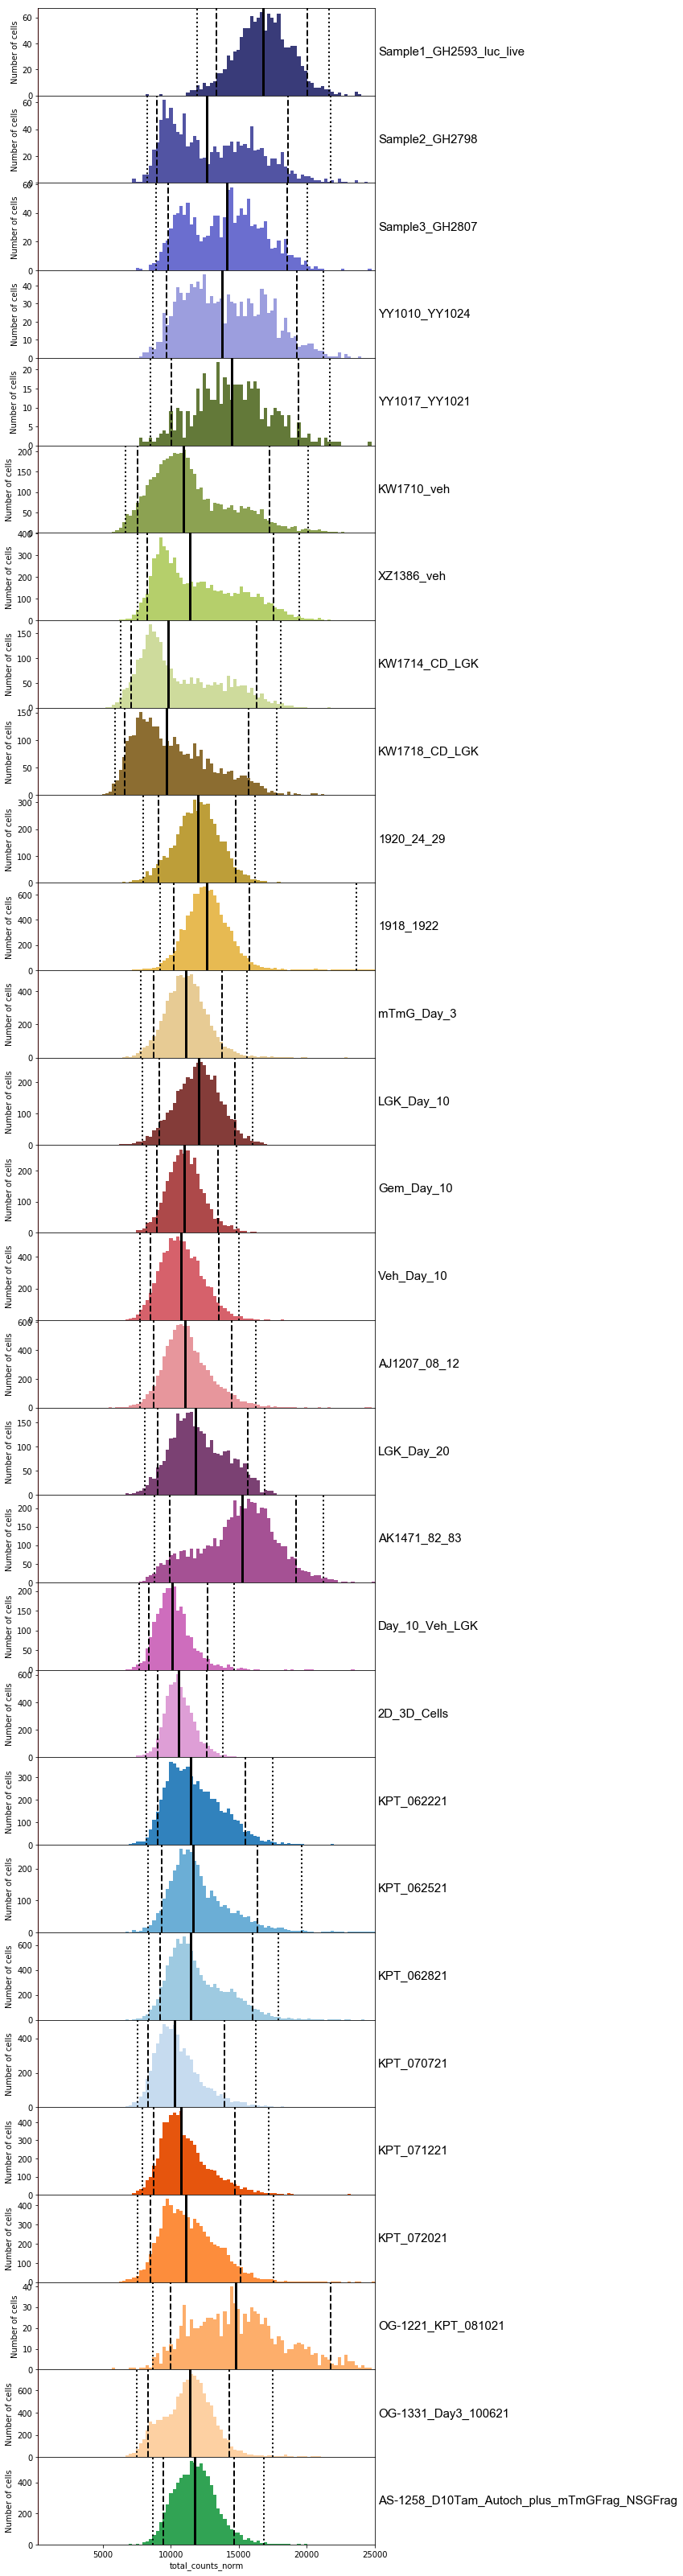

In [24]:
QC_hist_v1(X,
           'total_counts_norm',
           'batch',
           cmap_groups={g:plt.cm.tab20b(i/20) if i<20 else plt.cm.tab20c((i-20)/20) for i, g in enumerate(return_unique(X.obs['batch']))},
           xlim=(250,25000), 
           thr = 200)

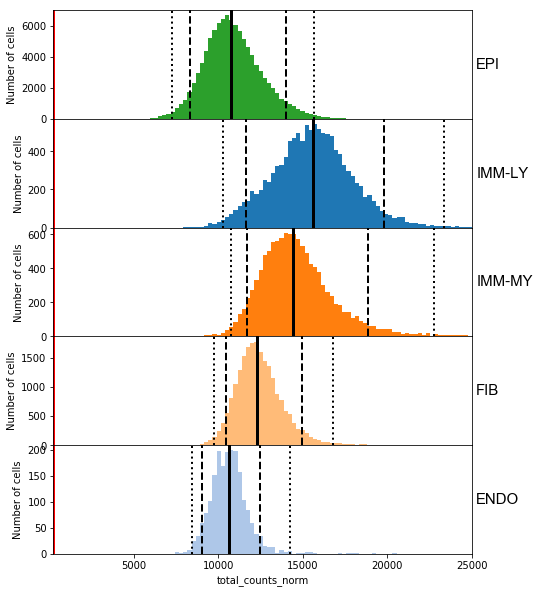

In [25]:
QC_hist_v1(X,
           'total_counts_norm',
           'cl_pp',
           xlim=(250,25000), 
           thr = 200)

## Checkpoint

In [26]:
X.write_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))